In [1]:
from sklearn.model_selection import train_test_split


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score , accuracy_score, precision_score
from sklearn import svm
from plot_metric.functions import BinaryClassification

%matplotlib inline

In [2]:
df_hash = pd.read_csv('hashed_feature.csv')
df_tab = pd.read_csv('tabular_data.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

<AxesSubplot:>

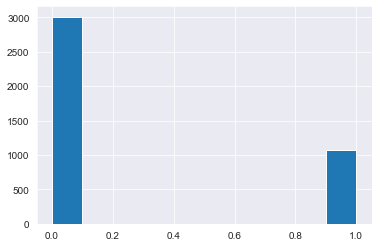

In [55]:
df_train['target'].hist()

In [4]:
df_train.target.value_counts().reset_index()

,index,target
0,0,3009
1,1,1075


In [5]:
df_train_1 = df_train.query('target==1')
df_train_0 = df_train.query('target==0').sample(n=1075, random_state=7)
tgt_train = pd.concat([df_train_1, df_train_0])

In [6]:
id_test = df_test['id']
id_train = tgt_train['id']
df_id = pd.concat([id_test, id_train])

In [7]:
df_tab = df_tab.loc[df_tab['id'].isin(df_id)]
df_hash = df_hash.loc[df_hash['id'].isin(df_id)]

## Replacing missing values with mean

In [8]:
from sklearn.impute import SimpleImputer
imp_ = SimpleImputer(missing_values=np.nan, strategy='median')

df_tab.loc[:,'feature_0':'feature_24'] = df_tab.loc[:,'feature_0':'feature_24'].fillna(np.nan)
df_tab.loc[:,'feature_0':'feature_24'] = imp_.fit_transform(df_tab.loc[:,'feature_0':'feature_24'].values)

In [9]:
df_tab.loc[:,'feature_26':'feature_49'] = df_tab.loc[:,'feature_26':'feature_49'].fillna(np.nan)
df_tab.loc[:,'feature_26':'feature_49'] = imp_.fit_transform(df_tab.loc[:,'feature_26':'feature_49'].values)

### Categorical variable encoding

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_hash['hs_50'] = le.fit_transform(df_hash['feature_50'].astype(str))

In [11]:
df_tab_hs = df_tab[['id', 'feature_25']].copy()
df_tab_hs['hs_25'] = le.fit_transform(df_tab_hs['feature_25'].astype(str))

### Normalize Numeric Values

In [12]:
df_nums_scaled = df_tab = df_tab.drop(['feature_25'], axis = 1)
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
df_nums_scaled.loc[:, 'feature_0':] = feature_scaler.fit_transform(df_nums_scaled.loc[:, 'feature_0':])

## Groupby ID

In [13]:
df_nums_scaled = df_nums_scaled.loc[:,'id':'feature_49'].groupby(['id'],as_index=False).sum()

In [14]:
new_ohe = pd.get_dummies(df_hash, columns = ['hs_50']).groupby(['id'],as_index=False).sum()

In [15]:
new_ohe_2 = pd.get_dummies(df_tab_hs, columns = ['hs_25']).groupby(['id'],as_index=False).sum()

### Combining encoded categorical data with standardized numeric variables

In [16]:
df_hs_25 = pd.merge(df_nums_scaled, 
                   new_ohe,
                   on = 'id')

In [17]:
df_final = pd.merge(df_hs_25, 
                   new_ohe_2,
                   on = 'id')

## Modeling

In [18]:
df_final = df_final.sample(frac=1).reset_index(drop=True)

In [19]:
X = df_final[:2900]
Tst = df_final[2900:]

In [20]:
# Add target variable to the data
Xy = pd.merge(X, 
              tgt_train, 
              on = 'id')

In [21]:
y = Xy['target']
X = Xy.drop(['target'], axis = 1)

In [22]:
import catboost
print(catboost.__version__)
from catboost import CatBoostClassifier

1.0.6


In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.33,random_state=15)

### Catboost

In [24]:
# Категориальные переменные 
cat_features = np.where(X.dtypes != float)[0]
cat_features

array([   0,    1,   51, ..., 5031, 5032, 5033])

In [25]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
clf = CatBoostClassifier()


params = {'depth': range(3,7),
#           'iterations': [500],
#           'l2_leaf_reg': [1e-20],
#           'learning_rate': [0.6],
#           'leaf_estimation_iterations': [10],
#           'logging_level': ['Silent'],
#           'loss_function': ['Logloss'],
#           'random_seed': [7]
         }
scorer = make_scorer(accuracy_score)
clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=5)

In [26]:
clf_grid.fit(X_train, y_train)
best_param = clf_grid.best_params_
best_param

Learning rate set to 0.007773
0:	learn: 0.6921220	total: 65.7ms	remaining: 1m 5s
1:	learn: 0.6909099	total: 70.9ms	remaining: 35.4s
2:	learn: 0.6898144	total: 75.4ms	remaining: 25.1s
3:	learn: 0.6889743	total: 80.1ms	remaining: 19.9s
4:	learn: 0.6879868	total: 84.3ms	remaining: 16.8s
5:	learn: 0.6871320	total: 88.8ms	remaining: 14.7s
6:	learn: 0.6863844	total: 93.1ms	remaining: 13.2s
7:	learn: 0.6852771	total: 97.4ms	remaining: 12.1s
8:	learn: 0.6842678	total: 102ms	remaining: 11.2s
9:	learn: 0.6835542	total: 106ms	remaining: 10.5s
10:	learn: 0.6825551	total: 111ms	remaining: 10s
11:	learn: 0.6818224	total: 116ms	remaining: 9.51s
12:	learn: 0.6809957	total: 120ms	remaining: 9.12s
13:	learn: 0.6802584	total: 124ms	remaining: 8.75s
14:	learn: 0.6793742	total: 129ms	remaining: 8.44s
15:	learn: 0.6782833	total: 133ms	remaining: 8.17s
16:	learn: 0.6777376	total: 138ms	remaining: 7.95s
17:	learn: 0.6769427	total: 142ms	remaining: 7.76s
18:	learn: 0.6761797	total: 147ms	remaining: 7.57s
19:	l

189:	learn: 0.5989745	total: 989ms	remaining: 4.21s
190:	learn: 0.5986089	total: 995ms	remaining: 4.21s
191:	learn: 0.5984295	total: 1s	remaining: 4.21s
192:	learn: 0.5982863	total: 1s	remaining: 4.21s
193:	learn: 0.5980197	total: 1.01s	remaining: 4.2s
194:	learn: 0.5974843	total: 1.02s	remaining: 4.2s
195:	learn: 0.5972445	total: 1.02s	remaining: 4.2s
196:	learn: 0.5969874	total: 1.03s	remaining: 4.2s
197:	learn: 0.5967086	total: 1.04s	remaining: 4.2s
198:	learn: 0.5964510	total: 1.04s	remaining: 4.19s
199:	learn: 0.5961913	total: 1.05s	remaining: 4.19s
200:	learn: 0.5960739	total: 1.05s	remaining: 4.19s
201:	learn: 0.5959567	total: 1.06s	remaining: 4.18s
202:	learn: 0.5957208	total: 1.06s	remaining: 4.18s
203:	learn: 0.5953918	total: 1.07s	remaining: 4.17s
204:	learn: 0.5951196	total: 1.07s	remaining: 4.17s
205:	learn: 0.5948597	total: 1.08s	remaining: 4.16s
206:	learn: 0.5945451	total: 1.08s	remaining: 4.16s
207:	learn: 0.5944202	total: 1.09s	remaining: 4.15s
208:	learn: 0.5942029	t

363:	learn: 0.5618361	total: 1.78s	remaining: 3.12s
364:	learn: 0.5617704	total: 1.79s	remaining: 3.11s
365:	learn: 0.5616460	total: 1.79s	remaining: 3.11s
366:	learn: 0.5614909	total: 1.8s	remaining: 3.1s
367:	learn: 0.5613357	total: 1.8s	remaining: 3.1s
368:	learn: 0.5611509	total: 1.81s	remaining: 3.09s
369:	learn: 0.5609842	total: 1.81s	remaining: 3.09s
370:	learn: 0.5607098	total: 1.82s	remaining: 3.08s
371:	learn: 0.5605917	total: 1.82s	remaining: 3.08s
372:	learn: 0.5603270	total: 1.83s	remaining: 3.07s
373:	learn: 0.5601580	total: 1.83s	remaining: 3.07s
374:	learn: 0.5599802	total: 1.84s	remaining: 3.06s
375:	learn: 0.5599278	total: 1.84s	remaining: 3.06s
376:	learn: 0.5597123	total: 1.85s	remaining: 3.05s
377:	learn: 0.5595959	total: 1.85s	remaining: 3.05s
378:	learn: 0.5594377	total: 1.85s	remaining: 3.04s
379:	learn: 0.5593110	total: 1.86s	remaining: 3.04s
380:	learn: 0.5591790	total: 1.86s	remaining: 3.03s
381:	learn: 0.5590004	total: 1.87s	remaining: 3.03s
382:	learn: 0.55

547:	learn: 0.5326905	total: 2.58s	remaining: 2.13s
548:	learn: 0.5324372	total: 2.58s	remaining: 2.12s
549:	learn: 0.5322762	total: 2.59s	remaining: 2.12s
550:	learn: 0.5320768	total: 2.59s	remaining: 2.11s
551:	learn: 0.5320217	total: 2.6s	remaining: 2.11s
552:	learn: 0.5318399	total: 2.6s	remaining: 2.1s
553:	learn: 0.5316839	total: 2.61s	remaining: 2.1s
554:	learn: 0.5314802	total: 2.61s	remaining: 2.09s
555:	learn: 0.5313924	total: 2.62s	remaining: 2.09s
556:	learn: 0.5312353	total: 2.62s	remaining: 2.08s
557:	learn: 0.5310718	total: 2.62s	remaining: 2.08s
558:	learn: 0.5309776	total: 2.63s	remaining: 2.07s
559:	learn: 0.5308237	total: 2.63s	remaining: 2.07s
560:	learn: 0.5307257	total: 2.64s	remaining: 2.06s
561:	learn: 0.5305843	total: 2.64s	remaining: 2.06s
562:	learn: 0.5304984	total: 2.65s	remaining: 2.05s
563:	learn: 0.5303857	total: 2.65s	remaining: 2.05s
564:	learn: 0.5302375	total: 2.65s	remaining: 2.04s
565:	learn: 0.5300973	total: 2.66s	remaining: 2.04s
566:	learn: 0.52

733:	learn: 0.5052295	total: 3.37s	remaining: 1.22s
734:	learn: 0.5051067	total: 3.38s	remaining: 1.22s
735:	learn: 0.5050379	total: 3.38s	remaining: 1.21s
736:	learn: 0.5049028	total: 3.38s	remaining: 1.21s
737:	learn: 0.5047842	total: 3.39s	remaining: 1.2s
738:	learn: 0.5046335	total: 3.39s	remaining: 1.2s
739:	learn: 0.5045318	total: 3.4s	remaining: 1.19s
740:	learn: 0.5043477	total: 3.4s	remaining: 1.19s
741:	learn: 0.5042593	total: 3.41s	remaining: 1.18s
742:	learn: 0.5040590	total: 3.41s	remaining: 1.18s
743:	learn: 0.5039070	total: 3.42s	remaining: 1.18s
744:	learn: 0.5036653	total: 3.42s	remaining: 1.17s
745:	learn: 0.5035831	total: 3.42s	remaining: 1.17s
746:	learn: 0.5034282	total: 3.43s	remaining: 1.16s
747:	learn: 0.5032982	total: 3.43s	remaining: 1.16s
748:	learn: 0.5031703	total: 3.44s	remaining: 1.15s
749:	learn: 0.5030221	total: 3.44s	remaining: 1.15s
750:	learn: 0.5029055	total: 3.45s	remaining: 1.14s
751:	learn: 0.5027453	total: 3.45s	remaining: 1.14s
752:	learn: 0.50

909:	learn: 0.4730360	total: 4.17s	remaining: 412ms
910:	learn: 0.4728367	total: 4.17s	remaining: 408ms
911:	learn: 0.4725819	total: 4.18s	remaining: 403ms
912:	learn: 0.4723810	total: 4.18s	remaining: 398ms
913:	learn: 0.4721892	total: 4.19s	remaining: 394ms
914:	learn: 0.4720427	total: 4.19s	remaining: 389ms
915:	learn: 0.4717021	total: 4.2s	remaining: 385ms
916:	learn: 0.4715529	total: 4.2s	remaining: 380ms
917:	learn: 0.4713301	total: 4.21s	remaining: 376ms
918:	learn: 0.4710363	total: 4.21s	remaining: 371ms
919:	learn: 0.4708541	total: 4.22s	remaining: 367ms
920:	learn: 0.4705765	total: 4.22s	remaining: 362ms
921:	learn: 0.4704093	total: 4.23s	remaining: 358ms
922:	learn: 0.4701348	total: 4.23s	remaining: 353ms
923:	learn: 0.4699271	total: 4.24s	remaining: 348ms
924:	learn: 0.4696862	total: 4.24s	remaining: 344ms
925:	learn: 0.4693836	total: 4.25s	remaining: 339ms
926:	learn: 0.4692247	total: 4.25s	remaining: 335ms
927:	learn: 0.4689766	total: 4.26s	remaining: 330ms
928:	learn: 0.

88:	learn: 0.6360120	total: 397ms	remaining: 4.06s
89:	learn: 0.6353960	total: 402ms	remaining: 4.07s
90:	learn: 0.6347849	total: 407ms	remaining: 4.06s
91:	learn: 0.6342977	total: 411ms	remaining: 4.06s
92:	learn: 0.6337612	total: 416ms	remaining: 4.05s
93:	learn: 0.6333832	total: 421ms	remaining: 4.05s
94:	learn: 0.6326373	total: 425ms	remaining: 4.05s
95:	learn: 0.6321972	total: 430ms	remaining: 4.04s
96:	learn: 0.6318251	total: 434ms	remaining: 4.04s
97:	learn: 0.6315802	total: 439ms	remaining: 4.04s
98:	learn: 0.6310426	total: 443ms	remaining: 4.03s
99:	learn: 0.6305374	total: 448ms	remaining: 4.03s
100:	learn: 0.6302138	total: 453ms	remaining: 4.03s
101:	learn: 0.6299011	total: 458ms	remaining: 4.03s
102:	learn: 0.6294222	total: 463ms	remaining: 4.03s
103:	learn: 0.6290885	total: 468ms	remaining: 4.03s
104:	learn: 0.6284885	total: 472ms	remaining: 4.02s
105:	learn: 0.6280561	total: 476ms	remaining: 4.01s
106:	learn: 0.6276737	total: 481ms	remaining: 4.01s
107:	learn: 0.6273183	to

264:	learn: 0.5824722	total: 1.19s	remaining: 3.29s
265:	learn: 0.5823484	total: 1.19s	remaining: 3.29s
266:	learn: 0.5820711	total: 1.2s	remaining: 3.29s
267:	learn: 0.5818870	total: 1.2s	remaining: 3.28s
268:	learn: 0.5817133	total: 1.21s	remaining: 3.28s
269:	learn: 0.5813160	total: 1.21s	remaining: 3.28s
270:	learn: 0.5809493	total: 1.22s	remaining: 3.27s
271:	learn: 0.5806873	total: 1.22s	remaining: 3.27s
272:	learn: 0.5805944	total: 1.23s	remaining: 3.27s
273:	learn: 0.5803484	total: 1.23s	remaining: 3.26s
274:	learn: 0.5802469	total: 1.24s	remaining: 3.26s
275:	learn: 0.5799551	total: 1.24s	remaining: 3.25s
276:	learn: 0.5796008	total: 1.24s	remaining: 3.25s
277:	learn: 0.5795203	total: 1.25s	remaining: 3.24s
278:	learn: 0.5793534	total: 1.25s	remaining: 3.24s
279:	learn: 0.5791769	total: 1.26s	remaining: 3.23s
280:	learn: 0.5790112	total: 1.26s	remaining: 3.23s
281:	learn: 0.5789074	total: 1.27s	remaining: 3.22s
282:	learn: 0.5788431	total: 1.27s	remaining: 3.22s
283:	learn: 0.

437:	learn: 0.5503368	total: 1.98s	remaining: 2.54s
438:	learn: 0.5502408	total: 1.98s	remaining: 2.54s
439:	learn: 0.5500417	total: 1.99s	remaining: 2.53s
440:	learn: 0.5498154	total: 1.99s	remaining: 2.53s
441:	learn: 0.5496926	total: 2s	remaining: 2.52s
442:	learn: 0.5495564	total: 2s	remaining: 2.52s
443:	learn: 0.5493669	total: 2.01s	remaining: 2.52s
444:	learn: 0.5491163	total: 2.02s	remaining: 2.51s
445:	learn: 0.5490386	total: 2.02s	remaining: 2.51s
446:	learn: 0.5490097	total: 2.02s	remaining: 2.5s
447:	learn: 0.5488058	total: 2.03s	remaining: 2.5s
448:	learn: 0.5486004	total: 2.03s	remaining: 2.5s
449:	learn: 0.5485063	total: 2.04s	remaining: 2.49s
450:	learn: 0.5483667	total: 2.04s	remaining: 2.49s
451:	learn: 0.5482194	total: 2.05s	remaining: 2.48s
452:	learn: 0.5481180	total: 2.05s	remaining: 2.48s
453:	learn: 0.5479413	total: 2.06s	remaining: 2.48s
454:	learn: 0.5477614	total: 2.06s	remaining: 2.47s
455:	learn: 0.5476866	total: 2.07s	remaining: 2.47s
456:	learn: 0.5475933

603:	learn: 0.5259688	total: 2.77s	remaining: 1.82s
604:	learn: 0.5258137	total: 2.78s	remaining: 1.81s
605:	learn: 0.5257628	total: 2.78s	remaining: 1.81s
606:	learn: 0.5256550	total: 2.79s	remaining: 1.8s
607:	learn: 0.5254568	total: 2.79s	remaining: 1.8s
608:	learn: 0.5253056	total: 2.79s	remaining: 1.79s
609:	learn: 0.5251674	total: 2.8s	remaining: 1.79s
610:	learn: 0.5250679	total: 2.81s	remaining: 1.79s
611:	learn: 0.5249333	total: 2.81s	remaining: 1.78s
612:	learn: 0.5247514	total: 2.82s	remaining: 1.78s
613:	learn: 0.5245760	total: 2.82s	remaining: 1.77s
614:	learn: 0.5243658	total: 2.83s	remaining: 1.77s
615:	learn: 0.5242991	total: 2.83s	remaining: 1.76s
616:	learn: 0.5242226	total: 2.83s	remaining: 1.76s
617:	learn: 0.5241066	total: 2.84s	remaining: 1.75s
618:	learn: 0.5238509	total: 2.85s	remaining: 1.75s
619:	learn: 0.5236452	total: 2.85s	remaining: 1.75s
620:	learn: 0.5235239	total: 2.85s	remaining: 1.74s
621:	learn: 0.5234528	total: 2.86s	remaining: 1.74s
622:	learn: 0.5

771:	learn: 0.5025468	total: 3.57s	remaining: 1.05s
772:	learn: 0.5023779	total: 3.57s	remaining: 1.05s
773:	learn: 0.5023312	total: 3.58s	remaining: 1.04s
774:	learn: 0.5021855	total: 3.58s	remaining: 1.04s
775:	learn: 0.5020583	total: 3.59s	remaining: 1.03s
776:	learn: 0.5018513	total: 3.59s	remaining: 1.03s
777:	learn: 0.5017832	total: 3.6s	remaining: 1.03s
778:	learn: 0.5016358	total: 3.6s	remaining: 1.02s
779:	learn: 0.5015526	total: 3.61s	remaining: 1.02s
780:	learn: 0.5015101	total: 3.61s	remaining: 1.01s
781:	learn: 0.5013147	total: 3.62s	remaining: 1.01s
782:	learn: 0.5011236	total: 3.62s	remaining: 1s
783:	learn: 0.5009984	total: 3.63s	remaining: 999ms
784:	learn: 0.5007259	total: 3.63s	remaining: 995ms
785:	learn: 0.5005339	total: 3.64s	remaining: 990ms
786:	learn: 0.5002966	total: 3.64s	remaining: 986ms
787:	learn: 0.5001647	total: 3.65s	remaining: 981ms
788:	learn: 0.5001076	total: 3.65s	remaining: 977ms
789:	learn: 0.4997643	total: 3.66s	remaining: 972ms
790:	learn: 0.499

935:	learn: 0.4727042	total: 4.36s	remaining: 298ms
936:	learn: 0.4725492	total: 4.37s	remaining: 294ms
937:	learn: 0.4724490	total: 4.37s	remaining: 289ms
938:	learn: 0.4723680	total: 4.38s	remaining: 284ms
939:	learn: 0.4721654	total: 4.38s	remaining: 280ms
940:	learn: 0.4720504	total: 4.39s	remaining: 275ms
941:	learn: 0.4717417	total: 4.39s	remaining: 271ms
942:	learn: 0.4712995	total: 4.4s	remaining: 266ms
943:	learn: 0.4712079	total: 4.4s	remaining: 261ms
944:	learn: 0.4710448	total: 4.41s	remaining: 257ms
945:	learn: 0.4707851	total: 4.41s	remaining: 252ms
946:	learn: 0.4705584	total: 4.42s	remaining: 247ms
947:	learn: 0.4704525	total: 4.42s	remaining: 243ms
948:	learn: 0.4702752	total: 4.43s	remaining: 238ms
949:	learn: 0.4700935	total: 4.43s	remaining: 233ms
950:	learn: 0.4699698	total: 4.44s	remaining: 229ms
951:	learn: 0.4699160	total: 4.44s	remaining: 224ms
952:	learn: 0.4697821	total: 4.45s	remaining: 219ms
953:	learn: 0.4695074	total: 4.45s	remaining: 215ms
954:	learn: 0.

131:	learn: 0.6155153	total: 591ms	remaining: 3.88s
132:	learn: 0.6151920	total: 595ms	remaining: 3.88s
133:	learn: 0.6147809	total: 600ms	remaining: 3.88s
134:	learn: 0.6146257	total: 604ms	remaining: 3.87s
135:	learn: 0.6143613	total: 609ms	remaining: 3.87s
136:	learn: 0.6141834	total: 613ms	remaining: 3.86s
137:	learn: 0.6136995	total: 620ms	remaining: 3.87s
138:	learn: 0.6133219	total: 624ms	remaining: 3.87s
139:	learn: 0.6127235	total: 629ms	remaining: 3.86s
140:	learn: 0.6122788	total: 634ms	remaining: 3.86s
141:	learn: 0.6119101	total: 638ms	remaining: 3.85s
142:	learn: 0.6113018	total: 643ms	remaining: 3.85s
143:	learn: 0.6110281	total: 647ms	remaining: 3.85s
144:	learn: 0.6105091	total: 651ms	remaining: 3.84s
145:	learn: 0.6102969	total: 656ms	remaining: 3.83s
146:	learn: 0.6100033	total: 660ms	remaining: 3.83s
147:	learn: 0.6098159	total: 664ms	remaining: 3.82s
148:	learn: 0.6094620	total: 669ms	remaining: 3.82s
149:	learn: 0.6090216	total: 673ms	remaining: 3.81s
150:	learn: 

315:	learn: 0.5682414	total: 1.38s	remaining: 2.99s
316:	learn: 0.5680509	total: 1.39s	remaining: 2.99s
317:	learn: 0.5677840	total: 1.39s	remaining: 2.99s
318:	learn: 0.5673639	total: 1.4s	remaining: 2.98s
319:	learn: 0.5671723	total: 1.4s	remaining: 2.98s
320:	learn: 0.5670549	total: 1.41s	remaining: 2.97s
321:	learn: 0.5667335	total: 1.41s	remaining: 2.97s
322:	learn: 0.5663311	total: 1.42s	remaining: 2.97s
323:	learn: 0.5660193	total: 1.42s	remaining: 2.96s
324:	learn: 0.5658682	total: 1.42s	remaining: 2.96s
325:	learn: 0.5657415	total: 1.43s	remaining: 2.95s
326:	learn: 0.5654372	total: 1.43s	remaining: 2.95s
327:	learn: 0.5652674	total: 1.44s	remaining: 2.94s
328:	learn: 0.5650643	total: 1.44s	remaining: 2.94s
329:	learn: 0.5648851	total: 1.45s	remaining: 2.94s
330:	learn: 0.5646781	total: 1.45s	remaining: 2.93s
331:	learn: 0.5645184	total: 1.45s	remaining: 2.93s
332:	learn: 0.5642167	total: 1.46s	remaining: 2.92s
333:	learn: 0.5640115	total: 1.46s	remaining: 2.92s
334:	learn: 0.

499:	learn: 0.5382697	total: 2.18s	remaining: 2.18s
500:	learn: 0.5381095	total: 2.18s	remaining: 2.17s
501:	learn: 0.5380167	total: 2.19s	remaining: 2.17s
502:	learn: 0.5378635	total: 2.19s	remaining: 2.17s
503:	learn: 0.5376976	total: 2.2s	remaining: 2.16s
504:	learn: 0.5375581	total: 2.2s	remaining: 2.16s
505:	learn: 0.5374206	total: 2.21s	remaining: 2.15s
506:	learn: 0.5372414	total: 2.21s	remaining: 2.15s
507:	learn: 0.5370144	total: 2.21s	remaining: 2.15s
508:	learn: 0.5368679	total: 2.22s	remaining: 2.14s
509:	learn: 0.5366816	total: 2.22s	remaining: 2.14s
510:	learn: 0.5364787	total: 2.23s	remaining: 2.13s
511:	learn: 0.5363533	total: 2.23s	remaining: 2.13s
512:	learn: 0.5362956	total: 2.24s	remaining: 2.12s
513:	learn: 0.5360737	total: 2.24s	remaining: 2.12s
514:	learn: 0.5359763	total: 2.24s	remaining: 2.11s
515:	learn: 0.5356289	total: 2.25s	remaining: 2.11s
516:	learn: 0.5355291	total: 2.25s	remaining: 2.1s
517:	learn: 0.5354208	total: 2.26s	remaining: 2.1s
518:	learn: 0.53

686:	learn: 0.5109088	total: 2.98s	remaining: 1.36s
687:	learn: 0.5108411	total: 2.98s	remaining: 1.35s
688:	learn: 0.5107555	total: 2.99s	remaining: 1.35s
689:	learn: 0.5105217	total: 2.99s	remaining: 1.34s
690:	learn: 0.5103512	total: 3s	remaining: 1.34s
691:	learn: 0.5102303	total: 3s	remaining: 1.33s
692:	learn: 0.5101088	total: 3s	remaining: 1.33s
693:	learn: 0.5099008	total: 3.01s	remaining: 1.33s
694:	learn: 0.5098686	total: 3.01s	remaining: 1.32s
695:	learn: 0.5097365	total: 3.02s	remaining: 1.32s
696:	learn: 0.5094881	total: 3.02s	remaining: 1.31s
697:	learn: 0.5093482	total: 3.03s	remaining: 1.31s
698:	learn: 0.5091172	total: 3.03s	remaining: 1.3s
699:	learn: 0.5089894	total: 3.03s	remaining: 1.3s
700:	learn: 0.5089375	total: 3.04s	remaining: 1.3s
701:	learn: 0.5088379	total: 3.04s	remaining: 1.29s
702:	learn: 0.5087209	total: 3.05s	remaining: 1.29s
703:	learn: 0.5086200	total: 3.05s	remaining: 1.28s
704:	learn: 0.5085355	total: 3.06s	remaining: 1.28s
705:	learn: 0.5084536	to

872:	learn: 0.4793369	total: 3.77s	remaining: 549ms
873:	learn: 0.4792253	total: 3.78s	remaining: 545ms
874:	learn: 0.4790296	total: 3.78s	remaining: 541ms
875:	learn: 0.4787955	total: 3.79s	remaining: 536ms
876:	learn: 0.4785997	total: 3.79s	remaining: 532ms
877:	learn: 0.4782672	total: 3.8s	remaining: 528ms
878:	learn: 0.4780445	total: 3.8s	remaining: 523ms
879:	learn: 0.4779450	total: 3.81s	remaining: 519ms
880:	learn: 0.4776724	total: 3.81s	remaining: 515ms
881:	learn: 0.4774204	total: 3.81s	remaining: 510ms
882:	learn: 0.4772427	total: 3.82s	remaining: 506ms
883:	learn: 0.4769869	total: 3.82s	remaining: 502ms
884:	learn: 0.4768191	total: 3.83s	remaining: 497ms
885:	learn: 0.4766003	total: 3.83s	remaining: 493ms
886:	learn: 0.4763182	total: 3.84s	remaining: 489ms
887:	learn: 0.4761783	total: 3.84s	remaining: 484ms
888:	learn: 0.4759197	total: 3.84s	remaining: 480ms
889:	learn: 0.4756465	total: 3.85s	remaining: 476ms
890:	learn: 0.4752761	total: 3.85s	remaining: 471ms
891:	learn: 0.

44:	learn: 0.6566581	total: 194ms	remaining: 4.11s
45:	learn: 0.6561136	total: 198ms	remaining: 4.11s
46:	learn: 0.6553814	total: 202ms	remaining: 4.1s
47:	learn: 0.6547435	total: 207ms	remaining: 4.1s
48:	learn: 0.6539033	total: 211ms	remaining: 4.1s
49:	learn: 0.6535723	total: 215ms	remaining: 4.09s
50:	learn: 0.6527565	total: 220ms	remaining: 4.09s
51:	learn: 0.6519258	total: 224ms	remaining: 4.09s
52:	learn: 0.6515187	total: 229ms	remaining: 4.09s
53:	learn: 0.6509488	total: 233ms	remaining: 4.08s
54:	learn: 0.6503978	total: 238ms	remaining: 4.09s
55:	learn: 0.6498522	total: 243ms	remaining: 4.09s
56:	learn: 0.6490328	total: 247ms	remaining: 4.09s
57:	learn: 0.6485507	total: 252ms	remaining: 4.08s
58:	learn: 0.6479578	total: 256ms	remaining: 4.08s
59:	learn: 0.6475342	total: 260ms	remaining: 4.08s
60:	learn: 0.6469633	total: 265ms	remaining: 4.07s
61:	learn: 0.6461643	total: 269ms	remaining: 4.07s
62:	learn: 0.6458009	total: 273ms	remaining: 4.06s
63:	learn: 0.6452910	total: 277ms	

229:	learn: 0.5819515	total: 988ms	remaining: 3.31s
230:	learn: 0.5816172	total: 992ms	remaining: 3.3s
231:	learn: 0.5811476	total: 996ms	remaining: 3.3s
232:	learn: 0.5808801	total: 1s	remaining: 3.29s
233:	learn: 0.5805272	total: 1s	remaining: 3.29s
234:	learn: 0.5802797	total: 1.01s	remaining: 3.28s
235:	learn: 0.5801602	total: 1.01s	remaining: 3.28s
236:	learn: 0.5799678	total: 1.02s	remaining: 3.28s
237:	learn: 0.5797184	total: 1.02s	remaining: 3.27s
238:	learn: 0.5795445	total: 1.03s	remaining: 3.27s
239:	learn: 0.5793248	total: 1.03s	remaining: 3.26s
240:	learn: 0.5791408	total: 1.03s	remaining: 3.26s
241:	learn: 0.5788218	total: 1.04s	remaining: 3.26s
242:	learn: 0.5785883	total: 1.04s	remaining: 3.25s
243:	learn: 0.5782630	total: 1.05s	remaining: 3.25s
244:	learn: 0.5779858	total: 1.05s	remaining: 3.24s
245:	learn: 0.5778422	total: 1.06s	remaining: 3.24s
246:	learn: 0.5775114	total: 1.06s	remaining: 3.23s
247:	learn: 0.5772447	total: 1.06s	remaining: 3.23s
248:	learn: 0.577036

414:	learn: 0.5390638	total: 1.79s	remaining: 2.52s
415:	learn: 0.5387775	total: 1.79s	remaining: 2.51s
416:	learn: 0.5386538	total: 1.79s	remaining: 2.51s
417:	learn: 0.5384600	total: 1.8s	remaining: 2.5s
418:	learn: 0.5382557	total: 1.8s	remaining: 2.5s
419:	learn: 0.5381090	total: 1.81s	remaining: 2.5s
420:	learn: 0.5380439	total: 1.81s	remaining: 2.49s
421:	learn: 0.5380027	total: 1.82s	remaining: 2.49s
422:	learn: 0.5378476	total: 1.82s	remaining: 2.48s
423:	learn: 0.5377841	total: 1.83s	remaining: 2.48s
424:	learn: 0.5376382	total: 1.83s	remaining: 2.48s
425:	learn: 0.5374268	total: 1.84s	remaining: 2.47s
426:	learn: 0.5371971	total: 1.84s	remaining: 2.47s
427:	learn: 0.5371394	total: 1.84s	remaining: 2.46s
428:	learn: 0.5369434	total: 1.85s	remaining: 2.46s
429:	learn: 0.5366281	total: 1.85s	remaining: 2.46s
430:	learn: 0.5365056	total: 1.86s	remaining: 2.45s
431:	learn: 0.5361663	total: 1.86s	remaining: 2.45s
432:	learn: 0.5358556	total: 1.87s	remaining: 2.44s
433:	learn: 0.535

600:	learn: 0.5075046	total: 2.58s	remaining: 1.72s
601:	learn: 0.5072721	total: 2.59s	remaining: 1.71s
602:	learn: 0.5070260	total: 2.59s	remaining: 1.71s
603:	learn: 0.5067793	total: 2.6s	remaining: 1.7s
604:	learn: 0.5064748	total: 2.6s	remaining: 1.7s
605:	learn: 0.5063159	total: 2.61s	remaining: 1.69s
606:	learn: 0.5061598	total: 2.61s	remaining: 1.69s
607:	learn: 0.5058754	total: 2.62s	remaining: 1.69s
608:	learn: 0.5055972	total: 2.62s	remaining: 1.68s
609:	learn: 0.5054149	total: 2.62s	remaining: 1.68s
610:	learn: 0.5051564	total: 2.63s	remaining: 1.67s
611:	learn: 0.5050072	total: 2.63s	remaining: 1.67s
612:	learn: 0.5048229	total: 2.64s	remaining: 1.67s
613:	learn: 0.5046075	total: 2.64s	remaining: 1.66s
614:	learn: 0.5045173	total: 2.65s	remaining: 1.66s
615:	learn: 0.5043917	total: 2.65s	remaining: 1.65s
616:	learn: 0.5042783	total: 2.66s	remaining: 1.65s
617:	learn: 0.5040202	total: 2.66s	remaining: 1.65s
618:	learn: 0.5039207	total: 2.67s	remaining: 1.64s
619:	learn: 0.50

785:	learn: 0.4758410	total: 3.38s	remaining: 920ms
786:	learn: 0.4756017	total: 3.38s	remaining: 916ms
787:	learn: 0.4753594	total: 3.39s	remaining: 912ms
788:	learn: 0.4752767	total: 3.39s	remaining: 908ms
789:	learn: 0.4751644	total: 3.4s	remaining: 903ms
790:	learn: 0.4750806	total: 3.4s	remaining: 899ms
791:	learn: 0.4748869	total: 3.41s	remaining: 895ms
792:	learn: 0.4746708	total: 3.41s	remaining: 891ms
793:	learn: 0.4744569	total: 3.42s	remaining: 886ms
794:	learn: 0.4742403	total: 3.42s	remaining: 882ms
795:	learn: 0.4740719	total: 3.42s	remaining: 878ms
796:	learn: 0.4739337	total: 3.43s	remaining: 874ms
797:	learn: 0.4738036	total: 3.43s	remaining: 869ms
798:	learn: 0.4735934	total: 3.44s	remaining: 865ms
799:	learn: 0.4735284	total: 3.44s	remaining: 861ms
800:	learn: 0.4733213	total: 3.45s	remaining: 857ms
801:	learn: 0.4731323	total: 3.45s	remaining: 852ms
802:	learn: 0.4729421	total: 3.46s	remaining: 848ms
803:	learn: 0.4727900	total: 3.46s	remaining: 844ms
804:	learn: 0.

970:	learn: 0.4383599	total: 4.18s	remaining: 125ms
971:	learn: 0.4383097	total: 4.18s	remaining: 121ms
972:	learn: 0.4381413	total: 4.19s	remaining: 116ms
973:	learn: 0.4379318	total: 4.19s	remaining: 112ms
974:	learn: 0.4377345	total: 4.2s	remaining: 108ms
975:	learn: 0.4375108	total: 4.2s	remaining: 103ms
976:	learn: 0.4373569	total: 4.21s	remaining: 99ms
977:	learn: 0.4372691	total: 4.21s	remaining: 94.7ms
978:	learn: 0.4369946	total: 4.21s	remaining: 90.4ms
979:	learn: 0.4367038	total: 4.22s	remaining: 86.1ms
980:	learn: 0.4365437	total: 4.22s	remaining: 81.8ms
981:	learn: 0.4362908	total: 4.23s	remaining: 77.5ms
982:	learn: 0.4359696	total: 4.23s	remaining: 73.2ms
983:	learn: 0.4357991	total: 4.24s	remaining: 68.9ms
984:	learn: 0.4356846	total: 4.24s	remaining: 64.6ms
985:	learn: 0.4353674	total: 4.25s	remaining: 60.3ms
986:	learn: 0.4349605	total: 4.25s	remaining: 56ms
987:	learn: 0.4347801	total: 4.25s	remaining: 51.7ms
988:	learn: 0.4344814	total: 4.26s	remaining: 47.4ms
989:	

135:	learn: 0.6269196	total: 595ms	remaining: 3.78s
136:	learn: 0.6266170	total: 599ms	remaining: 3.77s
137:	learn: 0.6261374	total: 604ms	remaining: 3.77s
138:	learn: 0.6257213	total: 608ms	remaining: 3.77s
139:	learn: 0.6254269	total: 613ms	remaining: 3.77s
140:	learn: 0.6253185	total: 617ms	remaining: 3.76s
141:	learn: 0.6249703	total: 622ms	remaining: 3.76s
142:	learn: 0.6246028	total: 626ms	remaining: 3.75s
143:	learn: 0.6244356	total: 631ms	remaining: 3.75s
144:	learn: 0.6240495	total: 635ms	remaining: 3.75s
145:	learn: 0.6236549	total: 639ms	remaining: 3.74s
146:	learn: 0.6234755	total: 643ms	remaining: 3.73s
147:	learn: 0.6230374	total: 648ms	remaining: 3.73s
148:	learn: 0.6225880	total: 652ms	remaining: 3.72s
149:	learn: 0.6223812	total: 656ms	remaining: 3.72s
150:	learn: 0.6219564	total: 660ms	remaining: 3.71s
151:	learn: 0.6217296	total: 665ms	remaining: 3.71s
152:	learn: 0.6216105	total: 669ms	remaining: 3.7s
153:	learn: 0.6212513	total: 673ms	remaining: 3.7s
154:	learn: 0.

319:	learn: 0.5839449	total: 1.4s	remaining: 2.97s
320:	learn: 0.5838219	total: 1.4s	remaining: 2.97s
321:	learn: 0.5835650	total: 1.41s	remaining: 2.96s
322:	learn: 0.5833382	total: 1.41s	remaining: 2.96s
323:	learn: 0.5831371	total: 1.42s	remaining: 2.96s
324:	learn: 0.5828584	total: 1.42s	remaining: 2.95s
325:	learn: 0.5827339	total: 1.43s	remaining: 2.95s
326:	learn: 0.5825315	total: 1.43s	remaining: 2.94s
327:	learn: 0.5824344	total: 1.43s	remaining: 2.94s
328:	learn: 0.5822542	total: 1.44s	remaining: 2.94s
329:	learn: 0.5820530	total: 1.44s	remaining: 2.93s
330:	learn: 0.5819830	total: 1.45s	remaining: 2.93s
331:	learn: 0.5817743	total: 1.45s	remaining: 2.92s
332:	learn: 0.5816353	total: 1.46s	remaining: 2.92s
333:	learn: 0.5815491	total: 1.46s	remaining: 2.92s
334:	learn: 0.5814797	total: 1.47s	remaining: 2.91s
335:	learn: 0.5812172	total: 1.47s	remaining: 2.91s
336:	learn: 0.5809646	total: 1.48s	remaining: 2.9s
337:	learn: 0.5807731	total: 1.48s	remaining: 2.9s
338:	learn: 0.58

502:	learn: 0.5541647	total: 2.19s	remaining: 2.17s
503:	learn: 0.5537394	total: 2.2s	remaining: 2.16s
504:	learn: 0.5536078	total: 2.2s	remaining: 2.16s
505:	learn: 0.5533938	total: 2.21s	remaining: 2.16s
506:	learn: 0.5532238	total: 2.21s	remaining: 2.15s
507:	learn: 0.5530334	total: 2.22s	remaining: 2.15s
508:	learn: 0.5526940	total: 2.22s	remaining: 2.14s
509:	learn: 0.5526352	total: 2.23s	remaining: 2.14s
510:	learn: 0.5525059	total: 2.23s	remaining: 2.13s
511:	learn: 0.5523480	total: 2.23s	remaining: 2.13s
512:	learn: 0.5520605	total: 2.24s	remaining: 2.13s
513:	learn: 0.5519562	total: 2.24s	remaining: 2.12s
514:	learn: 0.5518322	total: 2.25s	remaining: 2.12s
515:	learn: 0.5517297	total: 2.25s	remaining: 2.11s
516:	learn: 0.5517210	total: 2.26s	remaining: 2.11s
517:	learn: 0.5515409	total: 2.26s	remaining: 2.1s
518:	learn: 0.5514432	total: 2.27s	remaining: 2.1s
519:	learn: 0.5513400	total: 2.27s	remaining: 2.1s
520:	learn: 0.5512554	total: 2.27s	remaining: 2.09s
521:	learn: 0.551

685:	learn: 0.5271925	total: 3s	remaining: 1.37s
686:	learn: 0.5270605	total: 3s	remaining: 1.37s
687:	learn: 0.5269059	total: 3s	remaining: 1.36s
688:	learn: 0.5267857	total: 3.01s	remaining: 1.36s
689:	learn: 0.5266789	total: 3.01s	remaining: 1.35s
690:	learn: 0.5264701	total: 3.02s	remaining: 1.35s
691:	learn: 0.5263384	total: 3.02s	remaining: 1.34s
692:	learn: 0.5262387	total: 3.03s	remaining: 1.34s
693:	learn: 0.5259407	total: 3.03s	remaining: 1.34s
694:	learn: 0.5256729	total: 3.04s	remaining: 1.33s
695:	learn: 0.5254715	total: 3.04s	remaining: 1.33s
696:	learn: 0.5252060	total: 3.04s	remaining: 1.32s
697:	learn: 0.5251365	total: 3.05s	remaining: 1.32s
698:	learn: 0.5250281	total: 3.05s	remaining: 1.31s
699:	learn: 0.5248994	total: 3.06s	remaining: 1.31s
700:	learn: 0.5247870	total: 3.06s	remaining: 1.31s
701:	learn: 0.5246352	total: 3.07s	remaining: 1.3s
702:	learn: 0.5245803	total: 3.07s	remaining: 1.3s
703:	learn: 0.5244456	total: 3.07s	remaining: 1.29s
704:	learn: 0.5243414	t

870:	learn: 0.4965088	total: 3.79s	remaining: 561ms
871:	learn: 0.4962231	total: 3.79s	remaining: 557ms
872:	learn: 0.4961225	total: 3.8s	remaining: 553ms
873:	learn: 0.4958989	total: 3.8s	remaining: 548ms
874:	learn: 0.4958161	total: 3.81s	remaining: 544ms
875:	learn: 0.4956241	total: 3.81s	remaining: 540ms
876:	learn: 0.4954508	total: 3.82s	remaining: 535ms
877:	learn: 0.4953752	total: 3.82s	remaining: 531ms
878:	learn: 0.4952383	total: 3.83s	remaining: 527ms
879:	learn: 0.4948764	total: 3.83s	remaining: 522ms
880:	learn: 0.4947706	total: 3.83s	remaining: 518ms
881:	learn: 0.4946337	total: 3.84s	remaining: 514ms
882:	learn: 0.4944893	total: 3.84s	remaining: 509ms
883:	learn: 0.4942112	total: 3.85s	remaining: 505ms
884:	learn: 0.4938643	total: 3.85s	remaining: 501ms
885:	learn: 0.4936395	total: 3.86s	remaining: 496ms
886:	learn: 0.4935143	total: 3.86s	remaining: 492ms
887:	learn: 0.4932065	total: 3.87s	remaining: 488ms
888:	learn: 0.4929126	total: 3.87s	remaining: 483ms
889:	learn: 0.

30:	learn: 0.6649916	total: 196ms	remaining: 6.13s
31:	learn: 0.6641816	total: 203ms	remaining: 6.13s
32:	learn: 0.6629782	total: 210ms	remaining: 6.14s
33:	learn: 0.6620863	total: 217ms	remaining: 6.17s
34:	learn: 0.6614571	total: 224ms	remaining: 6.18s
35:	learn: 0.6606219	total: 232ms	remaining: 6.21s
36:	learn: 0.6597752	total: 239ms	remaining: 6.21s
37:	learn: 0.6593174	total: 245ms	remaining: 6.2s
38:	learn: 0.6585430	total: 251ms	remaining: 6.18s
39:	learn: 0.6579661	total: 257ms	remaining: 6.17s
40:	learn: 0.6571798	total: 264ms	remaining: 6.17s
41:	learn: 0.6564199	total: 270ms	remaining: 6.15s
42:	learn: 0.6558826	total: 276ms	remaining: 6.13s
43:	learn: 0.6550118	total: 282ms	remaining: 6.12s
44:	learn: 0.6544126	total: 288ms	remaining: 6.1s
45:	learn: 0.6539687	total: 294ms	remaining: 6.09s
46:	learn: 0.6533064	total: 300ms	remaining: 6.08s
47:	learn: 0.6525610	total: 306ms	remaining: 6.07s
48:	learn: 0.6519022	total: 312ms	remaining: 6.05s
49:	learn: 0.6515259	total: 317ms

194:	learn: 0.5887971	total: 1.2s	remaining: 4.96s
195:	learn: 0.5884767	total: 1.21s	remaining: 4.96s
196:	learn: 0.5880440	total: 1.22s	remaining: 4.95s
197:	learn: 0.5877254	total: 1.22s	remaining: 4.95s
198:	learn: 0.5875094	total: 1.23s	remaining: 4.94s
199:	learn: 0.5871904	total: 1.24s	remaining: 4.94s
200:	learn: 0.5867294	total: 1.24s	remaining: 4.94s
201:	learn: 0.5865787	total: 1.25s	remaining: 4.93s
202:	learn: 0.5864174	total: 1.25s	remaining: 4.93s
203:	learn: 0.5861729	total: 1.26s	remaining: 4.92s
204:	learn: 0.5858306	total: 1.27s	remaining: 4.91s
205:	learn: 0.5855010	total: 1.27s	remaining: 4.91s
206:	learn: 0.5851713	total: 1.28s	remaining: 4.9s
207:	learn: 0.5850047	total: 1.28s	remaining: 4.89s
208:	learn: 0.5846804	total: 1.29s	remaining: 4.88s
209:	learn: 0.5843821	total: 1.29s	remaining: 4.88s
210:	learn: 0.5841971	total: 1.3s	remaining: 4.87s
211:	learn: 0.5839376	total: 1.31s	remaining: 4.86s
212:	learn: 0.5836847	total: 1.31s	remaining: 4.85s
213:	learn: 0.5

359:	learn: 0.5475493	total: 2.21s	remaining: 3.93s
360:	learn: 0.5474820	total: 2.22s	remaining: 3.92s
361:	learn: 0.5471892	total: 2.22s	remaining: 3.92s
362:	learn: 0.5470333	total: 2.23s	remaining: 3.91s
363:	learn: 0.5468740	total: 2.24s	remaining: 3.91s
364:	learn: 0.5467361	total: 2.24s	remaining: 3.9s
365:	learn: 0.5465258	total: 2.25s	remaining: 3.9s
366:	learn: 0.5462800	total: 2.26s	remaining: 3.89s
367:	learn: 0.5461666	total: 2.26s	remaining: 3.88s
368:	learn: 0.5459530	total: 2.27s	remaining: 3.88s
369:	learn: 0.5457225	total: 2.27s	remaining: 3.87s
370:	learn: 0.5453863	total: 2.28s	remaining: 3.87s
371:	learn: 0.5452400	total: 2.29s	remaining: 3.86s
372:	learn: 0.5449957	total: 2.29s	remaining: 3.85s
373:	learn: 0.5448432	total: 2.3s	remaining: 3.85s
374:	learn: 0.5447085	total: 2.31s	remaining: 3.84s
375:	learn: 0.5444746	total: 2.31s	remaining: 3.84s
376:	learn: 0.5442828	total: 2.32s	remaining: 3.83s
377:	learn: 0.5440666	total: 2.32s	remaining: 3.82s
378:	learn: 0.5

524:	learn: 0.5170653	total: 3.22s	remaining: 2.91s
525:	learn: 0.5168879	total: 3.22s	remaining: 2.9s
526:	learn: 0.5166487	total: 3.23s	remaining: 2.9s
527:	learn: 0.5164492	total: 3.23s	remaining: 2.89s
528:	learn: 0.5163789	total: 3.24s	remaining: 2.89s
529:	learn: 0.5162460	total: 3.25s	remaining: 2.88s
530:	learn: 0.5160709	total: 3.26s	remaining: 2.88s
531:	learn: 0.5159566	total: 3.26s	remaining: 2.87s
532:	learn: 0.5158498	total: 3.27s	remaining: 2.86s
533:	learn: 0.5155483	total: 3.27s	remaining: 2.86s
534:	learn: 0.5153460	total: 3.28s	remaining: 2.85s
535:	learn: 0.5151544	total: 3.29s	remaining: 2.85s
536:	learn: 0.5149045	total: 3.29s	remaining: 2.84s
537:	learn: 0.5145876	total: 3.3s	remaining: 2.83s
538:	learn: 0.5143470	total: 3.31s	remaining: 2.83s
539:	learn: 0.5141430	total: 3.31s	remaining: 2.82s
540:	learn: 0.5140182	total: 3.32s	remaining: 2.81s
541:	learn: 0.5139245	total: 3.32s	remaining: 2.81s
542:	learn: 0.5137878	total: 3.33s	remaining: 2.8s
543:	learn: 0.51

689:	learn: 0.4867768	total: 4.22s	remaining: 1.9s
690:	learn: 0.4865183	total: 4.22s	remaining: 1.89s
691:	learn: 0.4864314	total: 4.23s	remaining: 1.88s
692:	learn: 0.4861619	total: 4.24s	remaining: 1.88s
693:	learn: 0.4860688	total: 4.24s	remaining: 1.87s
694:	learn: 0.4857961	total: 4.25s	remaining: 1.86s
695:	learn: 0.4855226	total: 4.26s	remaining: 1.86s
696:	learn: 0.4853410	total: 4.26s	remaining: 1.85s
697:	learn: 0.4851295	total: 4.27s	remaining: 1.85s
698:	learn: 0.4848902	total: 4.28s	remaining: 1.84s
699:	learn: 0.4847450	total: 4.28s	remaining: 1.83s
700:	learn: 0.4846386	total: 4.29s	remaining: 1.83s
701:	learn: 0.4842355	total: 4.29s	remaining: 1.82s
702:	learn: 0.4840214	total: 4.3s	remaining: 1.82s
703:	learn: 0.4838904	total: 4.3s	remaining: 1.81s
704:	learn: 0.4837476	total: 4.31s	remaining: 1.8s
705:	learn: 0.4836523	total: 4.32s	remaining: 1.8s
706:	learn: 0.4835606	total: 4.32s	remaining: 1.79s
707:	learn: 0.4834272	total: 4.33s	remaining: 1.78s
708:	learn: 0.483

854:	learn: 0.4507135	total: 5.22s	remaining: 885ms
855:	learn: 0.4505215	total: 5.23s	remaining: 879ms
856:	learn: 0.4502835	total: 5.23s	remaining: 873ms
857:	learn: 0.4500958	total: 5.24s	remaining: 867ms
858:	learn: 0.4499771	total: 5.25s	remaining: 861ms
859:	learn: 0.4496151	total: 5.25s	remaining: 855ms
860:	learn: 0.4493483	total: 5.26s	remaining: 849ms
861:	learn: 0.4488376	total: 5.27s	remaining: 843ms
862:	learn: 0.4484370	total: 5.28s	remaining: 838ms
863:	learn: 0.4481985	total: 5.28s	remaining: 831ms
864:	learn: 0.4479189	total: 5.29s	remaining: 825ms
865:	learn: 0.4476745	total: 5.29s	remaining: 819ms
866:	learn: 0.4473149	total: 5.3s	remaining: 813ms
867:	learn: 0.4468539	total: 5.31s	remaining: 807ms
868:	learn: 0.4463898	total: 5.31s	remaining: 801ms
869:	learn: 0.4460371	total: 5.32s	remaining: 795ms
870:	learn: 0.4457908	total: 5.33s	remaining: 789ms
871:	learn: 0.4456579	total: 5.33s	remaining: 783ms
872:	learn: 0.4452706	total: 5.34s	remaining: 776ms
873:	learn: 0

23:	learn: 0.6701749	total: 195ms	remaining: 7.92s
24:	learn: 0.6694755	total: 203ms	remaining: 7.93s
25:	learn: 0.6685842	total: 211ms	remaining: 7.89s
26:	learn: 0.6683108	total: 219ms	remaining: 7.88s
27:	learn: 0.6674877	total: 227ms	remaining: 7.88s
28:	learn: 0.6666343	total: 235ms	remaining: 7.87s
29:	learn: 0.6658140	total: 243ms	remaining: 7.85s
30:	learn: 0.6651011	total: 251ms	remaining: 7.83s
31:	learn: 0.6643533	total: 260ms	remaining: 7.85s
32:	learn: 0.6634430	total: 267ms	remaining: 7.83s
33:	learn: 0.6625347	total: 275ms	remaining: 7.8s
34:	learn: 0.6617918	total: 282ms	remaining: 7.78s
35:	learn: 0.6612221	total: 290ms	remaining: 7.76s
36:	learn: 0.6604581	total: 298ms	remaining: 7.77s
37:	learn: 0.6598068	total: 307ms	remaining: 7.76s
38:	learn: 0.6588868	total: 315ms	remaining: 7.77s
39:	learn: 0.6581547	total: 324ms	remaining: 7.76s
40:	learn: 0.6572393	total: 332ms	remaining: 7.78s
41:	learn: 0.6565501	total: 343ms	remaining: 7.82s
42:	learn: 0.6557210	total: 351m

201:	learn: 0.5873628	total: 1.19s	remaining: 4.68s
202:	learn: 0.5868454	total: 1.19s	remaining: 4.67s
203:	learn: 0.5862557	total: 1.19s	remaining: 4.66s
204:	learn: 0.5861242	total: 1.2s	remaining: 4.65s
205:	learn: 0.5859521	total: 1.2s	remaining: 4.64s
206:	learn: 0.5856608	total: 1.21s	remaining: 4.63s
207:	learn: 0.5854898	total: 1.21s	remaining: 4.62s
208:	learn: 0.5852391	total: 1.22s	remaining: 4.62s
209:	learn: 0.5848920	total: 1.22s	remaining: 4.6s
210:	learn: 0.5846311	total: 1.23s	remaining: 4.59s
211:	learn: 0.5844671	total: 1.23s	remaining: 4.58s
212:	learn: 0.5841974	total: 1.24s	remaining: 4.57s
213:	learn: 0.5840908	total: 1.24s	remaining: 4.55s
214:	learn: 0.5839171	total: 1.24s	remaining: 4.54s
215:	learn: 0.5836883	total: 1.25s	remaining: 4.54s
216:	learn: 0.5831347	total: 1.25s	remaining: 4.52s
217:	learn: 0.5829381	total: 1.26s	remaining: 4.51s
218:	learn: 0.5827502	total: 1.26s	remaining: 4.5s
219:	learn: 0.5823889	total: 1.27s	remaining: 4.49s
220:	learn: 0.58

383:	learn: 0.5439698	total: 1.99s	remaining: 3.19s
384:	learn: 0.5438812	total: 1.99s	remaining: 3.18s
385:	learn: 0.5437322	total: 2s	remaining: 3.18s
386:	learn: 0.5435534	total: 2s	remaining: 3.17s
387:	learn: 0.5434334	total: 2.01s	remaining: 3.17s
388:	learn: 0.5433738	total: 2.01s	remaining: 3.16s
389:	learn: 0.5432170	total: 2.02s	remaining: 3.16s
390:	learn: 0.5430761	total: 2.02s	remaining: 3.15s
391:	learn: 0.5428661	total: 2.03s	remaining: 3.14s
392:	learn: 0.5426672	total: 2.03s	remaining: 3.14s
393:	learn: 0.5424564	total: 2.03s	remaining: 3.13s
394:	learn: 0.5422284	total: 2.04s	remaining: 3.12s
395:	learn: 0.5420295	total: 2.04s	remaining: 3.12s
396:	learn: 0.5417340	total: 2.05s	remaining: 3.11s
397:	learn: 0.5415004	total: 2.05s	remaining: 3.1s
398:	learn: 0.5413249	total: 2.06s	remaining: 3.1s
399:	learn: 0.5412597	total: 2.06s	remaining: 3.09s
400:	learn: 0.5410285	total: 2.06s	remaining: 3.08s
401:	learn: 0.5408703	total: 2.07s	remaining: 3.08s
402:	learn: 0.540682

567:	learn: 0.5113631	total: 2.78s	remaining: 2.12s
568:	learn: 0.5112301	total: 2.79s	remaining: 2.11s
569:	learn: 0.5111512	total: 2.79s	remaining: 2.11s
570:	learn: 0.5110820	total: 2.8s	remaining: 2.1s
571:	learn: 0.5109626	total: 2.8s	remaining: 2.1s
572:	learn: 0.5106879	total: 2.81s	remaining: 2.09s
573:	learn: 0.5105157	total: 2.81s	remaining: 2.09s
574:	learn: 0.5104262	total: 2.81s	remaining: 2.08s
575:	learn: 0.5102161	total: 2.82s	remaining: 2.08s
576:	learn: 0.5100156	total: 2.82s	remaining: 2.07s
577:	learn: 0.5097708	total: 2.83s	remaining: 2.06s
578:	learn: 0.5096729	total: 2.83s	remaining: 2.06s
579:	learn: 0.5095011	total: 2.84s	remaining: 2.05s
580:	learn: 0.5093443	total: 2.84s	remaining: 2.05s
581:	learn: 0.5091852	total: 2.85s	remaining: 2.04s
582:	learn: 0.5090976	total: 2.85s	remaining: 2.04s
583:	learn: 0.5090146	total: 2.85s	remaining: 2.03s
584:	learn: 0.5089448	total: 2.86s	remaining: 2.03s
585:	learn: 0.5088336	total: 2.86s	remaining: 2.02s
586:	learn: 0.50

746:	learn: 0.4807949	total: 3.58s	remaining: 1.21s
747:	learn: 0.4805430	total: 3.58s	remaining: 1.21s
748:	learn: 0.4803663	total: 3.59s	remaining: 1.2s
749:	learn: 0.4802268	total: 3.59s	remaining: 1.2s
750:	learn: 0.4800563	total: 3.6s	remaining: 1.19s
751:	learn: 0.4798554	total: 3.6s	remaining: 1.19s
752:	learn: 0.4796845	total: 3.61s	remaining: 1.18s
753:	learn: 0.4794040	total: 3.61s	remaining: 1.18s
754:	learn: 0.4792443	total: 3.62s	remaining: 1.17s
755:	learn: 0.4791509	total: 3.62s	remaining: 1.17s
756:	learn: 0.4790255	total: 3.62s	remaining: 1.16s
757:	learn: 0.4789159	total: 3.63s	remaining: 1.16s
758:	learn: 0.4787895	total: 3.63s	remaining: 1.15s
759:	learn: 0.4785728	total: 3.64s	remaining: 1.15s
760:	learn: 0.4784789	total: 3.64s	remaining: 1.14s
761:	learn: 0.4783614	total: 3.65s	remaining: 1.14s
762:	learn: 0.4781883	total: 3.65s	remaining: 1.13s
763:	learn: 0.4779798	total: 3.65s	remaining: 1.13s
764:	learn: 0.4778396	total: 3.66s	remaining: 1.12s
765:	learn: 0.47

931:	learn: 0.4394150	total: 4.38s	remaining: 319ms
932:	learn: 0.4392916	total: 4.38s	remaining: 315ms
933:	learn: 0.4389656	total: 4.39s	remaining: 310ms
934:	learn: 0.4385072	total: 4.39s	remaining: 305ms
935:	learn: 0.4383441	total: 4.39s	remaining: 301ms
936:	learn: 0.4378859	total: 4.4s	remaining: 296ms
937:	learn: 0.4377265	total: 4.4s	remaining: 291ms
938:	learn: 0.4373408	total: 4.41s	remaining: 286ms
939:	learn: 0.4371623	total: 4.41s	remaining: 282ms
940:	learn: 0.4368460	total: 4.42s	remaining: 277ms
941:	learn: 0.4366836	total: 4.42s	remaining: 272ms
942:	learn: 0.4363400	total: 4.43s	remaining: 268ms
943:	learn: 0.4361868	total: 4.43s	remaining: 263ms
944:	learn: 0.4359057	total: 4.43s	remaining: 258ms
945:	learn: 0.4357763	total: 4.44s	remaining: 253ms
946:	learn: 0.4351366	total: 4.44s	remaining: 249ms
947:	learn: 0.4346272	total: 4.45s	remaining: 244ms
948:	learn: 0.4343620	total: 4.45s	remaining: 239ms
949:	learn: 0.4342256	total: 4.46s	remaining: 234ms
950:	learn: 0.

136:	learn: 0.6075063	total: 592ms	remaining: 3.73s
137:	learn: 0.6071294	total: 597ms	remaining: 3.73s
138:	learn: 0.6066920	total: 601ms	remaining: 3.72s
139:	learn: 0.6061903	total: 605ms	remaining: 3.72s
140:	learn: 0.6056812	total: 610ms	remaining: 3.71s
141:	learn: 0.6052257	total: 614ms	remaining: 3.71s
142:	learn: 0.6049082	total: 619ms	remaining: 3.71s
143:	learn: 0.6046828	total: 623ms	remaining: 3.71s
144:	learn: 0.6044280	total: 627ms	remaining: 3.7s
145:	learn: 0.6039797	total: 631ms	remaining: 3.69s
146:	learn: 0.6035742	total: 636ms	remaining: 3.69s
147:	learn: 0.6032605	total: 640ms	remaining: 3.69s
148:	learn: 0.6029483	total: 644ms	remaining: 3.68s
149:	learn: 0.6026685	total: 649ms	remaining: 3.67s
150:	learn: 0.6021723	total: 652ms	remaining: 3.67s
151:	learn: 0.6019502	total: 657ms	remaining: 3.66s
152:	learn: 0.6014890	total: 661ms	remaining: 3.66s
153:	learn: 0.6011980	total: 665ms	remaining: 3.65s
154:	learn: 0.6004294	total: 669ms	remaining: 3.65s
155:	learn: 0

322:	learn: 0.5534628	total: 1.39s	remaining: 2.91s
323:	learn: 0.5532391	total: 1.39s	remaining: 2.91s
324:	learn: 0.5529220	total: 1.4s	remaining: 2.9s
325:	learn: 0.5526630	total: 1.4s	remaining: 2.9s
326:	learn: 0.5524242	total: 1.41s	remaining: 2.9s
327:	learn: 0.5522412	total: 1.41s	remaining: 2.89s
328:	learn: 0.5520177	total: 1.42s	remaining: 2.89s
329:	learn: 0.5518287	total: 1.42s	remaining: 2.89s
330:	learn: 0.5516557	total: 1.43s	remaining: 2.88s
331:	learn: 0.5514904	total: 1.43s	remaining: 2.88s
332:	learn: 0.5513482	total: 1.44s	remaining: 2.88s
333:	learn: 0.5510341	total: 1.44s	remaining: 2.87s
334:	learn: 0.5508667	total: 1.44s	remaining: 2.87s
335:	learn: 0.5507005	total: 1.45s	remaining: 2.86s
336:	learn: 0.5504760	total: 1.45s	remaining: 2.86s
337:	learn: 0.5501226	total: 1.46s	remaining: 2.85s
338:	learn: 0.5498277	total: 1.46s	remaining: 2.85s
339:	learn: 0.5496089	total: 1.47s	remaining: 2.84s
340:	learn: 0.5493371	total: 1.47s	remaining: 2.84s
341:	learn: 0.548

508:	learn: 0.5167947	total: 2.19s	remaining: 2.11s
509:	learn: 0.5167368	total: 2.19s	remaining: 2.11s
510:	learn: 0.5165643	total: 2.2s	remaining: 2.1s
511:	learn: 0.5164943	total: 2.2s	remaining: 2.1s
512:	learn: 0.5161573	total: 2.21s	remaining: 2.1s
513:	learn: 0.5159671	total: 2.21s	remaining: 2.09s
514:	learn: 0.5158909	total: 2.22s	remaining: 2.09s
515:	learn: 0.5157180	total: 2.22s	remaining: 2.08s
516:	learn: 0.5154470	total: 2.23s	remaining: 2.08s
517:	learn: 0.5152734	total: 2.23s	remaining: 2.08s
518:	learn: 0.5151714	total: 2.24s	remaining: 2.07s
519:	learn: 0.5149869	total: 2.24s	remaining: 2.07s
520:	learn: 0.5147350	total: 2.24s	remaining: 2.06s
521:	learn: 0.5145153	total: 2.25s	remaining: 2.06s
522:	learn: 0.5143263	total: 2.25s	remaining: 2.06s
523:	learn: 0.5139990	total: 2.26s	remaining: 2.05s
524:	learn: 0.5136807	total: 2.26s	remaining: 2.05s
525:	learn: 0.5135690	total: 2.27s	remaining: 2.04s
526:	learn: 0.5134753	total: 2.27s	remaining: 2.04s
527:	learn: 0.513

691:	learn: 0.4860978	total: 2.99s	remaining: 1.33s
692:	learn: 0.4858744	total: 2.99s	remaining: 1.32s
693:	learn: 0.4856569	total: 3s	remaining: 1.32s
694:	learn: 0.4853794	total: 3s	remaining: 1.32s
695:	learn: 0.4852308	total: 3.01s	remaining: 1.31s
696:	learn: 0.4849899	total: 3.01s	remaining: 1.31s
697:	learn: 0.4848608	total: 3.02s	remaining: 1.3s
698:	learn: 0.4847186	total: 3.02s	remaining: 1.3s
699:	learn: 0.4844671	total: 3.02s	remaining: 1.3s
700:	learn: 0.4842083	total: 3.03s	remaining: 1.29s
701:	learn: 0.4839373	total: 3.03s	remaining: 1.29s
702:	learn: 0.4838713	total: 3.04s	remaining: 1.28s
703:	learn: 0.4837371	total: 3.04s	remaining: 1.28s
704:	learn: 0.4836038	total: 3.05s	remaining: 1.27s
705:	learn: 0.4834099	total: 3.05s	remaining: 1.27s
706:	learn: 0.4831567	total: 3.05s	remaining: 1.26s
707:	learn: 0.4830529	total: 3.06s	remaining: 1.26s
708:	learn: 0.4828123	total: 3.06s	remaining: 1.26s
709:	learn: 0.4826113	total: 3.07s	remaining: 1.25s
710:	learn: 0.4823333

874:	learn: 0.4458904	total: 3.78s	remaining: 541ms
875:	learn: 0.4456590	total: 3.79s	remaining: 536ms
876:	learn: 0.4453918	total: 3.79s	remaining: 532ms
877:	learn: 0.4451167	total: 3.8s	remaining: 528ms
878:	learn: 0.4448181	total: 3.8s	remaining: 523ms
879:	learn: 0.4446457	total: 3.81s	remaining: 519ms
880:	learn: 0.4443446	total: 3.81s	remaining: 515ms
881:	learn: 0.4439937	total: 3.82s	remaining: 511ms
882:	learn: 0.4437402	total: 3.82s	remaining: 506ms
883:	learn: 0.4435480	total: 3.83s	remaining: 502ms
884:	learn: 0.4433635	total: 3.83s	remaining: 498ms
885:	learn: 0.4430126	total: 3.83s	remaining: 493ms
886:	learn: 0.4427882	total: 3.84s	remaining: 489ms
887:	learn: 0.4423465	total: 3.84s	remaining: 485ms
888:	learn: 0.4419040	total: 3.85s	remaining: 480ms
889:	learn: 0.4414853	total: 3.85s	remaining: 476ms
890:	learn: 0.4411816	total: 3.86s	remaining: 472ms
891:	learn: 0.4409441	total: 3.86s	remaining: 467ms
892:	learn: 0.4407234	total: 3.87s	remaining: 463ms
893:	learn: 0.

43:	learn: 0.6503883	total: 194ms	remaining: 4.22s
44:	learn: 0.6498366	total: 199ms	remaining: 4.23s
45:	learn: 0.6487338	total: 204ms	remaining: 4.22s
46:	learn: 0.6480345	total: 208ms	remaining: 4.22s
47:	learn: 0.6475014	total: 213ms	remaining: 4.23s
48:	learn: 0.6468290	total: 219ms	remaining: 4.25s
49:	learn: 0.6459891	total: 224ms	remaining: 4.25s
50:	learn: 0.6451688	total: 228ms	remaining: 4.24s
51:	learn: 0.6442864	total: 234ms	remaining: 4.26s
52:	learn: 0.6436669	total: 238ms	remaining: 4.26s
53:	learn: 0.6431824	total: 244ms	remaining: 4.27s
54:	learn: 0.6427766	total: 248ms	remaining: 4.26s
55:	learn: 0.6416184	total: 253ms	remaining: 4.26s
56:	learn: 0.6408386	total: 257ms	remaining: 4.26s
57:	learn: 0.6402146	total: 262ms	remaining: 4.25s
58:	learn: 0.6391560	total: 267ms	remaining: 4.26s
59:	learn: 0.6385100	total: 272ms	remaining: 4.26s
60:	learn: 0.6379313	total: 277ms	remaining: 4.26s
61:	learn: 0.6373270	total: 282ms	remaining: 4.27s
62:	learn: 0.6364866	total: 287

215:	learn: 0.5673493	total: 986ms	remaining: 3.58s
216:	learn: 0.5669806	total: 990ms	remaining: 3.57s
217:	learn: 0.5667321	total: 994ms	remaining: 3.57s
218:	learn: 0.5664500	total: 999ms	remaining: 3.56s
219:	learn: 0.5661089	total: 1s	remaining: 3.56s
220:	learn: 0.5658209	total: 1.01s	remaining: 3.55s
221:	learn: 0.5656176	total: 1.01s	remaining: 3.55s
222:	learn: 0.5651551	total: 1.02s	remaining: 3.55s
223:	learn: 0.5648519	total: 1.02s	remaining: 3.54s
224:	learn: 0.5645254	total: 1.03s	remaining: 3.54s
225:	learn: 0.5642966	total: 1.03s	remaining: 3.53s
226:	learn: 0.5638800	total: 1.04s	remaining: 3.53s
227:	learn: 0.5632576	total: 1.04s	remaining: 3.52s
228:	learn: 0.5630299	total: 1.04s	remaining: 3.52s
229:	learn: 0.5627014	total: 1.05s	remaining: 3.51s
230:	learn: 0.5625296	total: 1.05s	remaining: 3.51s
231:	learn: 0.5623055	total: 1.06s	remaining: 3.5s
232:	learn: 0.5620549	total: 1.06s	remaining: 3.5s
233:	learn: 0.5616342	total: 1.06s	remaining: 3.49s
234:	learn: 0.561

383:	learn: 0.5225675	total: 1.77s	remaining: 2.85s
384:	learn: 0.5223585	total: 1.78s	remaining: 2.84s
385:	learn: 0.5220119	total: 1.78s	remaining: 2.84s
386:	learn: 0.5218727	total: 1.79s	remaining: 2.83s
387:	learn: 0.5216257	total: 1.79s	remaining: 2.83s
388:	learn: 0.5213740	total: 1.8s	remaining: 2.83s
389:	learn: 0.5212084	total: 1.8s	remaining: 2.82s
390:	learn: 0.5209451	total: 1.81s	remaining: 2.82s
391:	learn: 0.5206394	total: 1.81s	remaining: 2.81s
392:	learn: 0.5201708	total: 1.82s	remaining: 2.81s
393:	learn: 0.5199578	total: 1.82s	remaining: 2.8s
394:	learn: 0.5198043	total: 1.83s	remaining: 2.8s
395:	learn: 0.5196278	total: 1.83s	remaining: 2.79s
396:	learn: 0.5193997	total: 1.84s	remaining: 2.79s
397:	learn: 0.5190844	total: 1.84s	remaining: 2.79s
398:	learn: 0.5188721	total: 1.85s	remaining: 2.78s
399:	learn: 0.5185101	total: 1.85s	remaining: 2.77s
400:	learn: 0.5183038	total: 1.85s	remaining: 2.77s
401:	learn: 0.5179741	total: 1.86s	remaining: 2.77s
402:	learn: 0.51

558:	learn: 0.4878408	total: 2.56s	remaining: 2.02s
559:	learn: 0.4876336	total: 2.57s	remaining: 2.02s
560:	learn: 0.4874967	total: 2.58s	remaining: 2.02s
561:	learn: 0.4873145	total: 2.58s	remaining: 2.01s
562:	learn: 0.4871469	total: 2.58s	remaining: 2.01s
563:	learn: 0.4870294	total: 2.59s	remaining: 2s
564:	learn: 0.4867900	total: 2.6s	remaining: 2s
565:	learn: 0.4867154	total: 2.6s	remaining: 1.99s
566:	learn: 0.4864724	total: 2.6s	remaining: 1.99s
567:	learn: 0.4863575	total: 2.61s	remaining: 1.98s
568:	learn: 0.4862158	total: 2.61s	remaining: 1.98s
569:	learn: 0.4858992	total: 2.62s	remaining: 1.97s
570:	learn: 0.4857323	total: 2.62s	remaining: 1.97s
571:	learn: 0.4854857	total: 2.63s	remaining: 1.96s
572:	learn: 0.4853379	total: 2.63s	remaining: 1.96s
573:	learn: 0.4853014	total: 2.63s	remaining: 1.96s
574:	learn: 0.4852224	total: 2.64s	remaining: 1.95s
575:	learn: 0.4850092	total: 2.64s	remaining: 1.95s
576:	learn: 0.4848953	total: 2.65s	remaining: 1.94s
577:	learn: 0.4847357

731:	learn: 0.4550356	total: 3.36s	remaining: 1.23s
732:	learn: 0.4548749	total: 3.37s	remaining: 1.23s
733:	learn: 0.4543019	total: 3.37s	remaining: 1.22s
734:	learn: 0.4541314	total: 3.38s	remaining: 1.22s
735:	learn: 0.4539670	total: 3.38s	remaining: 1.21s
736:	learn: 0.4539158	total: 3.39s	remaining: 1.21s
737:	learn: 0.4537099	total: 3.39s	remaining: 1.2s
738:	learn: 0.4534435	total: 3.4s	remaining: 1.2s
739:	learn: 0.4533178	total: 3.4s	remaining: 1.19s
740:	learn: 0.4531966	total: 3.4s	remaining: 1.19s
741:	learn: 0.4528934	total: 3.41s	remaining: 1.19s
742:	learn: 0.4527735	total: 3.41s	remaining: 1.18s
743:	learn: 0.4526234	total: 3.42s	remaining: 1.18s
744:	learn: 0.4524979	total: 3.42s	remaining: 1.17s
745:	learn: 0.4523840	total: 3.43s	remaining: 1.17s
746:	learn: 0.4522598	total: 3.43s	remaining: 1.16s
747:	learn: 0.4520367	total: 3.44s	remaining: 1.16s
748:	learn: 0.4517615	total: 3.44s	remaining: 1.15s
749:	learn: 0.4516632	total: 3.44s	remaining: 1.15s
750:	learn: 0.451

904:	learn: 0.4166868	total: 4.16s	remaining: 436ms
905:	learn: 0.4164480	total: 4.16s	remaining: 432ms
906:	learn: 0.4162202	total: 4.17s	remaining: 427ms
907:	learn: 0.4158352	total: 4.17s	remaining: 423ms
908:	learn: 0.4156494	total: 4.17s	remaining: 418ms
909:	learn: 0.4152298	total: 4.18s	remaining: 413ms
910:	learn: 0.4150821	total: 4.18s	remaining: 409ms
911:	learn: 0.4149252	total: 4.19s	remaining: 404ms
912:	learn: 0.4147198	total: 4.2s	remaining: 400ms
913:	learn: 0.4146415	total: 4.2s	remaining: 395ms
914:	learn: 0.4145394	total: 4.2s	remaining: 390ms
915:	learn: 0.4142622	total: 4.21s	remaining: 386ms
916:	learn: 0.4141517	total: 4.21s	remaining: 381ms
917:	learn: 0.4138572	total: 4.22s	remaining: 377ms
918:	learn: 0.4135377	total: 4.22s	remaining: 372ms
919:	learn: 0.4129360	total: 4.23s	remaining: 368ms
920:	learn: 0.4128574	total: 4.23s	remaining: 363ms
921:	learn: 0.4126697	total: 4.24s	remaining: 358ms
922:	learn: 0.4124342	total: 4.24s	remaining: 354ms
923:	learn: 0.4

88:	learn: 0.6358772	total: 395ms	remaining: 4.05s
89:	learn: 0.6353977	total: 400ms	remaining: 4.04s
90:	learn: 0.6348323	total: 405ms	remaining: 4.04s
91:	learn: 0.6344168	total: 410ms	remaining: 4.04s
92:	learn: 0.6341866	total: 415ms	remaining: 4.04s
93:	learn: 0.6335463	total: 420ms	remaining: 4.05s
94:	learn: 0.6331121	total: 424ms	remaining: 4.04s
95:	learn: 0.6326757	total: 429ms	remaining: 4.04s
96:	learn: 0.6322284	total: 434ms	remaining: 4.04s
97:	learn: 0.6317076	total: 439ms	remaining: 4.04s
98:	learn: 0.6313665	total: 443ms	remaining: 4.03s
99:	learn: 0.6311464	total: 448ms	remaining: 4.04s
100:	learn: 0.6309284	total: 453ms	remaining: 4.03s
101:	learn: 0.6307167	total: 458ms	remaining: 4.03s
102:	learn: 0.6303028	total: 462ms	remaining: 4.03s
103:	learn: 0.6299998	total: 467ms	remaining: 4.03s
104:	learn: 0.6295338	total: 473ms	remaining: 4.03s
105:	learn: 0.6286816	total: 477ms	remaining: 4.02s
106:	learn: 0.6281034	total: 483ms	remaining: 4.03s
107:	learn: 0.6277478	to

258:	learn: 0.5796793	total: 1.19s	remaining: 3.4s
259:	learn: 0.5794430	total: 1.19s	remaining: 3.4s
260:	learn: 0.5792922	total: 1.2s	remaining: 3.4s
261:	learn: 0.5790995	total: 1.2s	remaining: 3.39s
262:	learn: 0.5788038	total: 1.21s	remaining: 3.39s
263:	learn: 0.5785481	total: 1.21s	remaining: 3.38s
264:	learn: 0.5782359	total: 1.22s	remaining: 3.38s
265:	learn: 0.5779521	total: 1.22s	remaining: 3.38s
266:	learn: 0.5777938	total: 1.23s	remaining: 3.37s
267:	learn: 0.5774928	total: 1.23s	remaining: 3.37s
268:	learn: 0.5773166	total: 1.24s	remaining: 3.36s
269:	learn: 0.5770697	total: 1.24s	remaining: 3.36s
270:	learn: 0.5767873	total: 1.25s	remaining: 3.35s
271:	learn: 0.5764936	total: 1.25s	remaining: 3.35s
272:	learn: 0.5761131	total: 1.25s	remaining: 3.34s
273:	learn: 0.5757982	total: 1.26s	remaining: 3.34s
274:	learn: 0.5755679	total: 1.26s	remaining: 3.33s
275:	learn: 0.5750459	total: 1.27s	remaining: 3.33s
276:	learn: 0.5748604	total: 1.27s	remaining: 3.32s
277:	learn: 0.574

422:	learn: 0.5458811	total: 1.98s	remaining: 2.7s
423:	learn: 0.5456506	total: 1.99s	remaining: 2.7s
424:	learn: 0.5454700	total: 1.99s	remaining: 2.69s
425:	learn: 0.5452818	total: 2s	remaining: 2.69s
426:	learn: 0.5451666	total: 2s	remaining: 2.69s
427:	learn: 0.5450465	total: 2.01s	remaining: 2.68s
428:	learn: 0.5448815	total: 2.01s	remaining: 2.68s
429:	learn: 0.5447774	total: 2.02s	remaining: 2.67s
430:	learn: 0.5445958	total: 2.02s	remaining: 2.67s
431:	learn: 0.5445001	total: 2.02s	remaining: 2.66s
432:	learn: 0.5444066	total: 2.03s	remaining: 2.66s
433:	learn: 0.5441554	total: 2.03s	remaining: 2.65s
434:	learn: 0.5440082	total: 2.04s	remaining: 2.65s
435:	learn: 0.5438345	total: 2.04s	remaining: 2.64s
436:	learn: 0.5437213	total: 2.05s	remaining: 2.64s
437:	learn: 0.5436125	total: 2.05s	remaining: 2.63s
438:	learn: 0.5435015	total: 2.06s	remaining: 2.63s
439:	learn: 0.5433866	total: 2.06s	remaining: 2.63s
440:	learn: 0.5432833	total: 2.07s	remaining: 2.62s
441:	learn: 0.543134

602:	learn: 0.5165950	total: 2.78s	remaining: 1.83s
603:	learn: 0.5164919	total: 2.78s	remaining: 1.82s
604:	learn: 0.5163382	total: 2.79s	remaining: 1.82s
605:	learn: 0.5161196	total: 2.79s	remaining: 1.81s
606:	learn: 0.5160007	total: 2.79s	remaining: 1.81s
607:	learn: 0.5157904	total: 2.8s	remaining: 1.8s
608:	learn: 0.5155912	total: 2.8s	remaining: 1.8s
609:	learn: 0.5154662	total: 2.81s	remaining: 1.8s
610:	learn: 0.5153115	total: 2.81s	remaining: 1.79s
611:	learn: 0.5151836	total: 2.82s	remaining: 1.79s
612:	learn: 0.5150929	total: 2.82s	remaining: 1.78s
613:	learn: 0.5149648	total: 2.83s	remaining: 1.78s
614:	learn: 0.5148105	total: 2.83s	remaining: 1.77s
615:	learn: 0.5146179	total: 2.83s	remaining: 1.77s
616:	learn: 0.5144526	total: 2.84s	remaining: 1.76s
617:	learn: 0.5143899	total: 2.84s	remaining: 1.76s
618:	learn: 0.5142728	total: 2.85s	remaining: 1.75s
619:	learn: 0.5140955	total: 2.85s	remaining: 1.75s
620:	learn: 0.5139728	total: 2.85s	remaining: 1.74s
621:	learn: 0.513

780:	learn: 0.4856839	total: 3.57s	remaining: 1s
781:	learn: 0.4854727	total: 3.58s	remaining: 997ms
782:	learn: 0.4852952	total: 3.58s	remaining: 992ms
783:	learn: 0.4852037	total: 3.58s	remaining: 988ms
784:	learn: 0.4849364	total: 3.59s	remaining: 984ms
785:	learn: 0.4844779	total: 3.6s	remaining: 979ms
786:	learn: 0.4841929	total: 3.6s	remaining: 975ms
787:	learn: 0.4839306	total: 3.6s	remaining: 970ms
788:	learn: 0.4838015	total: 3.61s	remaining: 966ms
789:	learn: 0.4833449	total: 3.62s	remaining: 961ms
790:	learn: 0.4831080	total: 3.62s	remaining: 956ms
791:	learn: 0.4829300	total: 3.62s	remaining: 952ms
792:	learn: 0.4827159	total: 3.63s	remaining: 947ms
793:	learn: 0.4824749	total: 3.63s	remaining: 943ms
794:	learn: 0.4822958	total: 3.64s	remaining: 938ms
795:	learn: 0.4820537	total: 3.64s	remaining: 934ms
796:	learn: 0.4817500	total: 3.65s	remaining: 929ms
797:	learn: 0.4816978	total: 3.65s	remaining: 925ms
798:	learn: 0.4815298	total: 3.66s	remaining: 921ms
799:	learn: 0.4810

957:	learn: 0.4387358	total: 4.37s	remaining: 191ms
958:	learn: 0.4381001	total: 4.37s	remaining: 187ms
959:	learn: 0.4379541	total: 4.38s	remaining: 182ms
960:	learn: 0.4376103	total: 4.38s	remaining: 178ms
961:	learn: 0.4372727	total: 4.39s	remaining: 173ms
962:	learn: 0.4370779	total: 4.39s	remaining: 169ms
963:	learn: 0.4369333	total: 4.39s	remaining: 164ms
964:	learn: 0.4367582	total: 4.4s	remaining: 160ms
965:	learn: 0.4363823	total: 4.4s	remaining: 155ms
966:	learn: 0.4361583	total: 4.41s	remaining: 150ms
967:	learn: 0.4358694	total: 4.41s	remaining: 146ms
968:	learn: 0.4354625	total: 4.42s	remaining: 141ms
969:	learn: 0.4352785	total: 4.42s	remaining: 137ms
970:	learn: 0.4350005	total: 4.43s	remaining: 132ms
971:	learn: 0.4347937	total: 4.43s	remaining: 128ms
972:	learn: 0.4343900	total: 4.43s	remaining: 123ms
973:	learn: 0.4340475	total: 4.44s	remaining: 119ms
974:	learn: 0.4338137	total: 4.44s	remaining: 114ms
975:	learn: 0.4335010	total: 4.45s	remaining: 109ms
976:	learn: 0.

130:	learn: 0.6000980	total: 797ms	remaining: 5.28s
131:	learn: 0.5997142	total: 802ms	remaining: 5.28s
132:	learn: 0.5994486	total: 808ms	remaining: 5.27s
133:	learn: 0.5987574	total: 815ms	remaining: 5.26s
134:	learn: 0.5983843	total: 822ms	remaining: 5.26s
135:	learn: 0.5979038	total: 828ms	remaining: 5.26s
136:	learn: 0.5976005	total: 834ms	remaining: 5.25s
137:	learn: 0.5973073	total: 839ms	remaining: 5.24s
138:	learn: 0.5968118	total: 845ms	remaining: 5.24s
139:	learn: 0.5964656	total: 851ms	remaining: 5.23s
140:	learn: 0.5962518	total: 857ms	remaining: 5.22s
141:	learn: 0.5957481	total: 862ms	remaining: 5.21s
142:	learn: 0.5950152	total: 868ms	remaining: 5.2s
143:	learn: 0.5946281	total: 874ms	remaining: 5.19s
144:	learn: 0.5943472	total: 880ms	remaining: 5.19s
145:	learn: 0.5940732	total: 885ms	remaining: 5.18s
146:	learn: 0.5932924	total: 891ms	remaining: 5.17s
147:	learn: 0.5926988	total: 897ms	remaining: 5.16s
148:	learn: 0.5920622	total: 902ms	remaining: 5.15s
149:	learn: 0

294:	learn: 0.5441882	total: 1.79s	remaining: 4.29s
295:	learn: 0.5439314	total: 1.8s	remaining: 4.28s
296:	learn: 0.5437455	total: 1.8s	remaining: 4.27s
297:	learn: 0.5432893	total: 1.81s	remaining: 4.27s
298:	learn: 0.5430138	total: 1.82s	remaining: 4.26s
299:	learn: 0.5429087	total: 1.82s	remaining: 4.26s
300:	learn: 0.5426148	total: 1.83s	remaining: 4.25s
301:	learn: 0.5423675	total: 1.84s	remaining: 4.24s
302:	learn: 0.5421040	total: 1.84s	remaining: 4.24s
303:	learn: 0.5417700	total: 1.85s	remaining: 4.23s
304:	learn: 0.5414556	total: 1.85s	remaining: 4.22s
305:	learn: 0.5412734	total: 1.86s	remaining: 4.22s
306:	learn: 0.5411649	total: 1.86s	remaining: 4.21s
307:	learn: 0.5409699	total: 1.87s	remaining: 4.21s
308:	learn: 0.5406854	total: 1.88s	remaining: 4.2s
309:	learn: 0.5404315	total: 1.88s	remaining: 4.19s
310:	learn: 0.5399207	total: 1.89s	remaining: 4.18s
311:	learn: 0.5397477	total: 1.89s	remaining: 4.18s
312:	learn: 0.5394397	total: 1.9s	remaining: 4.17s
313:	learn: 0.53

457:	learn: 0.5071148	total: 2.79s	remaining: 3.3s
458:	learn: 0.5069751	total: 2.8s	remaining: 3.3s
459:	learn: 0.5065496	total: 2.8s	remaining: 3.29s
460:	learn: 0.5064458	total: 2.81s	remaining: 3.29s
461:	learn: 0.5060112	total: 2.82s	remaining: 3.28s
462:	learn: 0.5058821	total: 2.82s	remaining: 3.27s
463:	learn: 0.5056602	total: 2.83s	remaining: 3.27s
464:	learn: 0.5055267	total: 2.83s	remaining: 3.26s
465:	learn: 0.5051499	total: 2.84s	remaining: 3.25s
466:	learn: 0.5050259	total: 2.85s	remaining: 3.25s
467:	learn: 0.5046958	total: 2.85s	remaining: 3.24s
468:	learn: 0.5044926	total: 2.86s	remaining: 3.23s
469:	learn: 0.5043528	total: 2.86s	remaining: 3.23s
470:	learn: 0.5041598	total: 2.87s	remaining: 3.22s
471:	learn: 0.5037799	total: 2.88s	remaining: 3.22s
472:	learn: 0.5034725	total: 2.88s	remaining: 3.21s
473:	learn: 0.5031771	total: 2.89s	remaining: 3.2s
474:	learn: 0.5030157	total: 2.89s	remaining: 3.2s
475:	learn: 0.5028915	total: 2.9s	remaining: 3.19s
476:	learn: 0.50271

623:	learn: 0.4746414	total: 3.79s	remaining: 2.28s
624:	learn: 0.4745374	total: 3.79s	remaining: 2.28s
625:	learn: 0.4743839	total: 3.8s	remaining: 2.27s
626:	learn: 0.4741600	total: 3.81s	remaining: 2.27s
627:	learn: 0.4738341	total: 3.81s	remaining: 2.26s
628:	learn: 0.4736694	total: 3.82s	remaining: 2.25s
629:	learn: 0.4733628	total: 3.83s	remaining: 2.25s
630:	learn: 0.4731745	total: 3.83s	remaining: 2.24s
631:	learn: 0.4729173	total: 3.84s	remaining: 2.23s
632:	learn: 0.4728449	total: 3.84s	remaining: 2.23s
633:	learn: 0.4726427	total: 3.85s	remaining: 2.22s
634:	learn: 0.4721323	total: 3.85s	remaining: 2.22s
635:	learn: 0.4716833	total: 3.86s	remaining: 2.21s
636:	learn: 0.4714922	total: 3.87s	remaining: 2.2s
637:	learn: 0.4711566	total: 3.87s	remaining: 2.2s
638:	learn: 0.4705093	total: 3.88s	remaining: 2.19s
639:	learn: 0.4704070	total: 3.88s	remaining: 2.19s
640:	learn: 0.4703028	total: 3.89s	remaining: 2.18s
641:	learn: 0.4702530	total: 3.9s	remaining: 2.17s
642:	learn: 0.47

794:	learn: 0.4375568	total: 4.79s	remaining: 1.24s
795:	learn: 0.4374192	total: 4.8s	remaining: 1.23s
796:	learn: 0.4372196	total: 4.81s	remaining: 1.22s
797:	learn: 0.4368240	total: 4.82s	remaining: 1.22s
798:	learn: 0.4366069	total: 4.82s	remaining: 1.21s
799:	learn: 0.4362582	total: 4.83s	remaining: 1.21s
800:	learn: 0.4356560	total: 4.83s	remaining: 1.2s
801:	learn: 0.4351932	total: 4.84s	remaining: 1.19s
802:	learn: 0.4349766	total: 4.84s	remaining: 1.19s
803:	learn: 0.4347345	total: 4.85s	remaining: 1.18s
804:	learn: 0.4345234	total: 4.86s	remaining: 1.18s
805:	learn: 0.4343654	total: 4.86s	remaining: 1.17s
806:	learn: 0.4341412	total: 4.87s	remaining: 1.16s
807:	learn: 0.4338937	total: 4.87s	remaining: 1.16s
808:	learn: 0.4336961	total: 4.88s	remaining: 1.15s
809:	learn: 0.4335303	total: 4.88s	remaining: 1.15s
810:	learn: 0.4333240	total: 4.89s	remaining: 1.14s
811:	learn: 0.4328789	total: 4.9s	remaining: 1.13s
812:	learn: 0.4327803	total: 4.9s	remaining: 1.13s
813:	learn: 0.43

961:	learn: 0.3830656	total: 5.79s	remaining: 229ms
962:	learn: 0.3826317	total: 5.8s	remaining: 223ms
963:	learn: 0.3824415	total: 5.81s	remaining: 217ms
964:	learn: 0.3818689	total: 5.81s	remaining: 211ms
965:	learn: 0.3813376	total: 5.82s	remaining: 205ms
966:	learn: 0.3811033	total: 5.83s	remaining: 199ms
967:	learn: 0.3808870	total: 5.83s	remaining: 193ms
968:	learn: 0.3804048	total: 5.84s	remaining: 187ms
969:	learn: 0.3802822	total: 5.84s	remaining: 181ms
970:	learn: 0.3799756	total: 5.85s	remaining: 175ms
971:	learn: 0.3794963	total: 5.86s	remaining: 169ms
972:	learn: 0.3790008	total: 5.86s	remaining: 163ms
973:	learn: 0.3783996	total: 5.87s	remaining: 157ms
974:	learn: 0.3779722	total: 5.87s	remaining: 151ms
975:	learn: 0.3774945	total: 5.88s	remaining: 145ms
976:	learn: 0.3773383	total: 5.88s	remaining: 139ms
977:	learn: 0.3769046	total: 5.89s	remaining: 133ms
978:	learn: 0.3767127	total: 5.9s	remaining: 126ms
979:	learn: 0.3762663	total: 5.9s	remaining: 120ms
980:	learn: 0.3

130:	learn: 0.6037548	total: 790ms	remaining: 5.24s
131:	learn: 0.6033334	total: 796ms	remaining: 5.24s
132:	learn: 0.6026557	total: 803ms	remaining: 5.23s
133:	learn: 0.6022499	total: 809ms	remaining: 5.23s
134:	learn: 0.6018996	total: 816ms	remaining: 5.23s
135:	learn: 0.6011261	total: 822ms	remaining: 5.22s
136:	learn: 0.6006845	total: 828ms	remaining: 5.21s
137:	learn: 0.6001464	total: 834ms	remaining: 5.21s
138:	learn: 0.5998356	total: 840ms	remaining: 5.2s
139:	learn: 0.5994424	total: 846ms	remaining: 5.2s
140:	learn: 0.5989490	total: 852ms	remaining: 5.19s
141:	learn: 0.5984028	total: 858ms	remaining: 5.18s
142:	learn: 0.5977820	total: 864ms	remaining: 5.18s
143:	learn: 0.5973174	total: 870ms	remaining: 5.17s
144:	learn: 0.5967954	total: 876ms	remaining: 5.16s
145:	learn: 0.5964558	total: 882ms	remaining: 5.16s
146:	learn: 0.5959236	total: 888ms	remaining: 5.15s
147:	learn: 0.5956531	total: 894ms	remaining: 5.14s
148:	learn: 0.5949426	total: 900ms	remaining: 5.14s
149:	learn: 0.

295:	learn: 0.5479466	total: 1.79s	remaining: 4.26s
296:	learn: 0.5478142	total: 1.8s	remaining: 4.25s
297:	learn: 0.5474101	total: 1.8s	remaining: 4.25s
298:	learn: 0.5471759	total: 1.81s	remaining: 4.24s
299:	learn: 0.5470237	total: 1.82s	remaining: 4.24s
300:	learn: 0.5467569	total: 1.82s	remaining: 4.23s
301:	learn: 0.5464036	total: 1.83s	remaining: 4.23s
302:	learn: 0.5461173	total: 1.83s	remaining: 4.22s
303:	learn: 0.5457560	total: 1.84s	remaining: 4.21s
304:	learn: 0.5453636	total: 1.85s	remaining: 4.21s
305:	learn: 0.5447158	total: 1.85s	remaining: 4.2s
306:	learn: 0.5446284	total: 1.86s	remaining: 4.2s
307:	learn: 0.5443038	total: 1.86s	remaining: 4.19s
308:	learn: 0.5441139	total: 1.87s	remaining: 4.18s
309:	learn: 0.5439157	total: 1.88s	remaining: 4.18s
310:	learn: 0.5437418	total: 1.88s	remaining: 4.17s
311:	learn: 0.5435441	total: 1.89s	remaining: 4.16s
312:	learn: 0.5434341	total: 1.89s	remaining: 4.16s
313:	learn: 0.5429220	total: 1.9s	remaining: 4.15s
314:	learn: 0.542

461:	learn: 0.5088290	total: 2.79s	remaining: 3.24s
462:	learn: 0.5086354	total: 2.79s	remaining: 3.24s
463:	learn: 0.5083970	total: 2.8s	remaining: 3.23s
464:	learn: 0.5082001	total: 2.81s	remaining: 3.23s
465:	learn: 0.5080406	total: 2.81s	remaining: 3.22s
466:	learn: 0.5078677	total: 2.82s	remaining: 3.21s
467:	learn: 0.5076942	total: 2.82s	remaining: 3.21s
468:	learn: 0.5075239	total: 2.83s	remaining: 3.2s
469:	learn: 0.5073971	total: 2.84s	remaining: 3.2s
470:	learn: 0.5070574	total: 2.84s	remaining: 3.19s
471:	learn: 0.5069890	total: 2.85s	remaining: 3.19s
472:	learn: 0.5067344	total: 2.85s	remaining: 3.18s
473:	learn: 0.5065885	total: 2.86s	remaining: 3.17s
474:	learn: 0.5064284	total: 2.87s	remaining: 3.17s
475:	learn: 0.5062192	total: 2.87s	remaining: 3.16s
476:	learn: 0.5060972	total: 2.88s	remaining: 3.15s
477:	learn: 0.5059842	total: 2.88s	remaining: 3.15s
478:	learn: 0.5058278	total: 2.89s	remaining: 3.14s
479:	learn: 0.5055372	total: 2.9s	remaining: 3.14s
480:	learn: 0.50

627:	learn: 0.4770110	total: 3.79s	remaining: 2.24s
628:	learn: 0.4768456	total: 3.79s	remaining: 2.24s
629:	learn: 0.4767066	total: 3.8s	remaining: 2.23s
630:	learn: 0.4763715	total: 3.8s	remaining: 2.23s
631:	learn: 0.4761487	total: 3.81s	remaining: 2.22s
632:	learn: 0.4760235	total: 3.82s	remaining: 2.21s
633:	learn: 0.4759194	total: 3.82s	remaining: 2.21s
634:	learn: 0.4756550	total: 3.83s	remaining: 2.2s
635:	learn: 0.4755504	total: 3.84s	remaining: 2.19s
636:	learn: 0.4753538	total: 3.84s	remaining: 2.19s
637:	learn: 0.4751991	total: 3.85s	remaining: 2.18s
638:	learn: 0.4750121	total: 3.85s	remaining: 2.18s
639:	learn: 0.4748008	total: 3.86s	remaining: 2.17s
640:	learn: 0.4746460	total: 3.87s	remaining: 2.17s
641:	learn: 0.4742961	total: 3.87s	remaining: 2.16s
642:	learn: 0.4740944	total: 3.88s	remaining: 2.15s
643:	learn: 0.4739220	total: 3.88s	remaining: 2.15s
644:	learn: 0.4737840	total: 3.89s	remaining: 2.14s
645:	learn: 0.4736410	total: 3.9s	remaining: 2.13s
646:	learn: 0.47

794:	learn: 0.4417773	total: 4.79s	remaining: 1.23s
795:	learn: 0.4416198	total: 4.79s	remaining: 1.23s
796:	learn: 0.4415146	total: 4.8s	remaining: 1.22s
797:	learn: 0.4414342	total: 4.8s	remaining: 1.22s
798:	learn: 0.4412696	total: 4.81s	remaining: 1.21s
799:	learn: 0.4411377	total: 4.82s	remaining: 1.2s
800:	learn: 0.4409262	total: 4.82s	remaining: 1.2s
801:	learn: 0.4407153	total: 4.83s	remaining: 1.19s
802:	learn: 0.4402989	total: 4.83s	remaining: 1.19s
803:	learn: 0.4401392	total: 4.84s	remaining: 1.18s
804:	learn: 0.4398153	total: 4.85s	remaining: 1.17s
805:	learn: 0.4392441	total: 4.85s	remaining: 1.17s
806:	learn: 0.4390656	total: 4.86s	remaining: 1.16s
807:	learn: 0.4388441	total: 4.86s	remaining: 1.16s
808:	learn: 0.4387301	total: 4.87s	remaining: 1.15s
809:	learn: 0.4383951	total: 4.88s	remaining: 1.14s
810:	learn: 0.4379210	total: 4.88s	remaining: 1.14s
811:	learn: 0.4376389	total: 4.89s	remaining: 1.13s
812:	learn: 0.4374959	total: 4.89s	remaining: 1.13s
813:	learn: 0.43

960:	learn: 0.3905823	total: 5.78s	remaining: 235ms
961:	learn: 0.3904635	total: 5.79s	remaining: 229ms
962:	learn: 0.3901771	total: 5.8s	remaining: 223ms
963:	learn: 0.3899058	total: 5.8s	remaining: 217ms
964:	learn: 0.3896896	total: 5.81s	remaining: 211ms
965:	learn: 0.3891535	total: 5.82s	remaining: 205ms
966:	learn: 0.3889740	total: 5.82s	remaining: 199ms
967:	learn: 0.3887706	total: 5.83s	remaining: 193ms
968:	learn: 0.3882977	total: 5.83s	remaining: 187ms
969:	learn: 0.3878907	total: 5.84s	remaining: 181ms
970:	learn: 0.3876046	total: 5.85s	remaining: 175ms
971:	learn: 0.3873615	total: 5.85s	remaining: 169ms
972:	learn: 0.3868495	total: 5.86s	remaining: 163ms
973:	learn: 0.3866706	total: 5.86s	remaining: 157ms
974:	learn: 0.3865395	total: 5.87s	remaining: 151ms
975:	learn: 0.3860893	total: 5.88s	remaining: 144ms
976:	learn: 0.3854032	total: 5.88s	remaining: 138ms
977:	learn: 0.3850654	total: 5.89s	remaining: 132ms
978:	learn: 0.3847132	total: 5.89s	remaining: 126ms
979:	learn: 0.

132:	learn: 0.5987179	total: 798ms	remaining: 5.2s
133:	learn: 0.5984073	total: 804ms	remaining: 5.2s
134:	learn: 0.5975242	total: 811ms	remaining: 5.19s
135:	learn: 0.5969200	total: 818ms	remaining: 5.19s
136:	learn: 0.5965388	total: 825ms	remaining: 5.2s
137:	learn: 0.5962085	total: 831ms	remaining: 5.19s
138:	learn: 0.5955976	total: 837ms	remaining: 5.18s
139:	learn: 0.5950250	total: 843ms	remaining: 5.18s
140:	learn: 0.5946347	total: 849ms	remaining: 5.17s
141:	learn: 0.5942243	total: 855ms	remaining: 5.17s
142:	learn: 0.5937839	total: 861ms	remaining: 5.16s
143:	learn: 0.5932127	total: 867ms	remaining: 5.15s
144:	learn: 0.5927397	total: 873ms	remaining: 5.14s
145:	learn: 0.5922061	total: 878ms	remaining: 5.14s
146:	learn: 0.5919204	total: 885ms	remaining: 5.14s
147:	learn: 0.5914304	total: 891ms	remaining: 5.13s
148:	learn: 0.5911068	total: 897ms	remaining: 5.13s
149:	learn: 0.5907851	total: 904ms	remaining: 5.12s
150:	learn: 0.5905369	total: 910ms	remaining: 5.11s
151:	learn: 0.5

298:	learn: 0.5420510	total: 1.8s	remaining: 4.21s
299:	learn: 0.5418990	total: 1.8s	remaining: 4.21s
300:	learn: 0.5416492	total: 1.81s	remaining: 4.2s
301:	learn: 0.5412876	total: 1.81s	remaining: 4.2s
302:	learn: 0.5411069	total: 1.82s	remaining: 4.19s
303:	learn: 0.5407292	total: 1.83s	remaining: 4.19s
304:	learn: 0.5405604	total: 1.83s	remaining: 4.18s
305:	learn: 0.5402825	total: 1.84s	remaining: 4.17s
306:	learn: 0.5400378	total: 1.85s	remaining: 4.17s
307:	learn: 0.5399112	total: 1.85s	remaining: 4.16s
308:	learn: 0.5396704	total: 1.86s	remaining: 4.16s
309:	learn: 0.5394898	total: 1.86s	remaining: 4.15s
310:	learn: 0.5392559	total: 1.87s	remaining: 4.14s
311:	learn: 0.5390147	total: 1.88s	remaining: 4.14s
312:	learn: 0.5387902	total: 1.88s	remaining: 4.13s
313:	learn: 0.5386850	total: 1.89s	remaining: 4.13s
314:	learn: 0.5384548	total: 1.89s	remaining: 4.12s
315:	learn: 0.5382879	total: 1.9s	remaining: 4.11s
316:	learn: 0.5381861	total: 1.91s	remaining: 4.11s
317:	learn: 0.538

465:	learn: 0.5064768	total: 2.8s	remaining: 3.21s
466:	learn: 0.5062735	total: 2.81s	remaining: 3.2s
467:	learn: 0.5060288	total: 2.81s	remaining: 3.2s
468:	learn: 0.5058992	total: 2.82s	remaining: 3.19s
469:	learn: 0.5058117	total: 2.82s	remaining: 3.19s
470:	learn: 0.5056729	total: 2.83s	remaining: 3.18s
471:	learn: 0.5055734	total: 2.84s	remaining: 3.17s
472:	learn: 0.5053581	total: 2.84s	remaining: 3.17s
473:	learn: 0.5052022	total: 2.85s	remaining: 3.16s
474:	learn: 0.5048989	total: 2.85s	remaining: 3.15s
475:	learn: 0.5046450	total: 2.86s	remaining: 3.15s
476:	learn: 0.5044750	total: 2.87s	remaining: 3.14s
477:	learn: 0.5041591	total: 2.87s	remaining: 3.14s
478:	learn: 0.5039924	total: 2.88s	remaining: 3.13s
479:	learn: 0.5039508	total: 2.89s	remaining: 3.13s
480:	learn: 0.5037929	total: 2.89s	remaining: 3.12s
481:	learn: 0.5035839	total: 2.9s	remaining: 3.11s
482:	learn: 0.5032091	total: 2.9s	remaining: 3.11s
483:	learn: 0.5029397	total: 2.91s	remaining: 3.1s
484:	learn: 0.5026

630:	learn: 0.4745237	total: 3.79s	remaining: 2.22s
631:	learn: 0.4743013	total: 3.8s	remaining: 2.21s
632:	learn: 0.4741852	total: 3.8s	remaining: 2.21s
633:	learn: 0.4739469	total: 3.81s	remaining: 2.2s
634:	learn: 0.4737630	total: 3.82s	remaining: 2.19s
635:	learn: 0.4734606	total: 3.82s	remaining: 2.19s
636:	learn: 0.4732758	total: 3.83s	remaining: 2.18s
637:	learn: 0.4730399	total: 3.83s	remaining: 2.17s
638:	learn: 0.4727391	total: 3.84s	remaining: 2.17s
639:	learn: 0.4725669	total: 3.85s	remaining: 2.16s
640:	learn: 0.4725052	total: 3.85s	remaining: 2.16s
641:	learn: 0.4723103	total: 3.86s	remaining: 2.15s
642:	learn: 0.4720594	total: 3.86s	remaining: 2.15s
643:	learn: 0.4719826	total: 3.87s	remaining: 2.14s
644:	learn: 0.4718018	total: 3.88s	remaining: 2.13s
645:	learn: 0.4716029	total: 3.88s	remaining: 2.13s
646:	learn: 0.4713875	total: 3.89s	remaining: 2.12s
647:	learn: 0.4712438	total: 3.89s	remaining: 2.12s
648:	learn: 0.4710663	total: 3.9s	remaining: 2.11s
649:	learn: 0.47

797:	learn: 0.4370905	total: 4.79s	remaining: 1.21s
798:	learn: 0.4366770	total: 4.8s	remaining: 1.21s
799:	learn: 0.4365216	total: 4.81s	remaining: 1.2s
800:	learn: 0.4364081	total: 4.81s	remaining: 1.2s
801:	learn: 0.4361494	total: 4.82s	remaining: 1.19s
802:	learn: 0.4358382	total: 4.83s	remaining: 1.18s
803:	learn: 0.4356514	total: 4.83s	remaining: 1.18s
804:	learn: 0.4355036	total: 4.84s	remaining: 1.17s
805:	learn: 0.4353082	total: 4.84s	remaining: 1.17s
806:	learn: 0.4351794	total: 4.85s	remaining: 1.16s
807:	learn: 0.4346797	total: 4.86s	remaining: 1.15s
808:	learn: 0.4345717	total: 4.86s	remaining: 1.15s
809:	learn: 0.4342394	total: 4.87s	remaining: 1.14s
810:	learn: 0.4339278	total: 4.88s	remaining: 1.14s
811:	learn: 0.4335534	total: 4.88s	remaining: 1.13s
812:	learn: 0.4333295	total: 4.89s	remaining: 1.12s
813:	learn: 0.4329969	total: 4.89s	remaining: 1.12s
814:	learn: 0.4328304	total: 4.9s	remaining: 1.11s
815:	learn: 0.4327575	total: 4.9s	remaining: 1.11s
816:	learn: 0.432

964:	learn: 0.3836673	total: 5.8s	remaining: 210ms
965:	learn: 0.3834823	total: 5.8s	remaining: 204ms
966:	learn: 0.3830394	total: 5.81s	remaining: 198ms
967:	learn: 0.3829181	total: 5.82s	remaining: 192ms
968:	learn: 0.3826263	total: 5.82s	remaining: 186ms
969:	learn: 0.3822741	total: 5.83s	remaining: 180ms
970:	learn: 0.3820788	total: 5.83s	remaining: 174ms
971:	learn: 0.3818857	total: 5.84s	remaining: 168ms
972:	learn: 0.3815260	total: 5.85s	remaining: 162ms
973:	learn: 0.3810623	total: 5.85s	remaining: 156ms
974:	learn: 0.3807010	total: 5.86s	remaining: 150ms
975:	learn: 0.3802337	total: 5.86s	remaining: 144ms
976:	learn: 0.3798919	total: 5.87s	remaining: 138ms
977:	learn: 0.3795516	total: 5.88s	remaining: 132ms
978:	learn: 0.3791299	total: 5.88s	remaining: 126ms
979:	learn: 0.3788901	total: 5.89s	remaining: 120ms
980:	learn: 0.3787511	total: 5.89s	remaining: 114ms
981:	learn: 0.3782611	total: 5.9s	remaining: 108ms
982:	learn: 0.3776842	total: 5.91s	remaining: 102ms
983:	learn: 0.3

131:	learn: 0.5890749	total: 792ms	remaining: 5.21s
132:	learn: 0.5884061	total: 797ms	remaining: 5.2s
133:	learn: 0.5876730	total: 804ms	remaining: 5.2s
134:	learn: 0.5871951	total: 811ms	remaining: 5.19s
135:	learn: 0.5867541	total: 817ms	remaining: 5.19s
136:	learn: 0.5862320	total: 823ms	remaining: 5.18s
137:	learn: 0.5857709	total: 829ms	remaining: 5.18s
138:	learn: 0.5854899	total: 835ms	remaining: 5.17s
139:	learn: 0.5850987	total: 841ms	remaining: 5.17s
140:	learn: 0.5846504	total: 847ms	remaining: 5.16s
141:	learn: 0.5839372	total: 853ms	remaining: 5.16s
142:	learn: 0.5832705	total: 859ms	remaining: 5.15s
143:	learn: 0.5829216	total: 865ms	remaining: 5.14s
144:	learn: 0.5826502	total: 871ms	remaining: 5.13s
145:	learn: 0.5821753	total: 876ms	remaining: 5.13s
146:	learn: 0.5815757	total: 882ms	remaining: 5.12s
147:	learn: 0.5810362	total: 888ms	remaining: 5.11s
148:	learn: 0.5807817	total: 894ms	remaining: 5.11s
149:	learn: 0.5805830	total: 900ms	remaining: 5.1s
150:	learn: 0.5

300:	learn: 0.5264970	total: 1.8s	remaining: 4.17s
301:	learn: 0.5263059	total: 1.8s	remaining: 4.17s
302:	learn: 0.5258077	total: 1.81s	remaining: 4.16s
303:	learn: 0.5256826	total: 1.82s	remaining: 4.16s
304:	learn: 0.5251173	total: 1.82s	remaining: 4.16s
305:	learn: 0.5248732	total: 1.83s	remaining: 4.15s
306:	learn: 0.5244796	total: 1.83s	remaining: 4.14s
307:	learn: 0.5242550	total: 1.84s	remaining: 4.14s
308:	learn: 0.5240633	total: 1.85s	remaining: 4.13s
309:	learn: 0.5236234	total: 1.85s	remaining: 4.13s
310:	learn: 0.5233180	total: 1.86s	remaining: 4.12s
311:	learn: 0.5231625	total: 1.86s	remaining: 4.11s
312:	learn: 0.5226787	total: 1.87s	remaining: 4.11s
313:	learn: 0.5222716	total: 1.88s	remaining: 4.1s
314:	learn: 0.5220242	total: 1.88s	remaining: 4.09s
315:	learn: 0.5217297	total: 1.89s	remaining: 4.09s
316:	learn: 0.5214909	total: 1.89s	remaining: 4.08s
317:	learn: 0.5212111	total: 1.9s	remaining: 4.08s
318:	learn: 0.5208975	total: 1.91s	remaining: 4.07s
319:	learn: 0.52

470:	learn: 0.4830308	total: 2.8s	remaining: 3.15s
471:	learn: 0.4827148	total: 2.81s	remaining: 3.14s
472:	learn: 0.4824689	total: 2.82s	remaining: 3.14s
473:	learn: 0.4823424	total: 2.82s	remaining: 3.13s
474:	learn: 0.4822311	total: 2.83s	remaining: 3.13s
475:	learn: 0.4820954	total: 2.83s	remaining: 3.12s
476:	learn: 0.4818218	total: 2.84s	remaining: 3.12s
477:	learn: 0.4816218	total: 2.85s	remaining: 3.11s
478:	learn: 0.4814302	total: 2.85s	remaining: 3.1s
479:	learn: 0.4810701	total: 2.86s	remaining: 3.1s
480:	learn: 0.4808617	total: 2.86s	remaining: 3.09s
481:	learn: 0.4806568	total: 2.87s	remaining: 3.08s
482:	learn: 0.4803719	total: 2.88s	remaining: 3.08s
483:	learn: 0.4801639	total: 2.88s	remaining: 3.07s
484:	learn: 0.4799548	total: 2.89s	remaining: 3.07s
485:	learn: 0.4797760	total: 2.89s	remaining: 3.06s
486:	learn: 0.4794491	total: 2.9s	remaining: 3.05s
487:	learn: 0.4788770	total: 2.9s	remaining: 3.05s
488:	learn: 0.4786743	total: 2.91s	remaining: 3.04s
489:	learn: 0.478

639:	learn: 0.4497646	total: 3.8s	remaining: 2.14s
640:	learn: 0.4496689	total: 3.81s	remaining: 2.13s
641:	learn: 0.4495350	total: 3.81s	remaining: 2.13s
642:	learn: 0.4493068	total: 3.82s	remaining: 2.12s
643:	learn: 0.4492157	total: 3.83s	remaining: 2.12s
644:	learn: 0.4490373	total: 3.83s	remaining: 2.11s
645:	learn: 0.4488401	total: 3.84s	remaining: 2.1s
646:	learn: 0.4486458	total: 3.85s	remaining: 2.1s
647:	learn: 0.4484731	total: 3.85s	remaining: 2.09s
648:	learn: 0.4483324	total: 3.86s	remaining: 2.09s
649:	learn: 0.4481159	total: 3.87s	remaining: 2.08s
650:	learn: 0.4478077	total: 3.87s	remaining: 2.08s
651:	learn: 0.4476970	total: 3.88s	remaining: 2.07s
652:	learn: 0.4475877	total: 3.88s	remaining: 2.06s
653:	learn: 0.4474871	total: 3.89s	remaining: 2.06s
654:	learn: 0.4473753	total: 3.9s	remaining: 2.05s
655:	learn: 0.4472346	total: 3.9s	remaining: 2.04s
656:	learn: 0.4470646	total: 3.91s	remaining: 2.04s
657:	learn: 0.4469297	total: 3.91s	remaining: 2.03s
658:	learn: 0.446

808:	learn: 0.4143987	total: 4.81s	remaining: 1.14s
809:	learn: 0.4143246	total: 4.82s	remaining: 1.13s
810:	learn: 0.4141660	total: 4.83s	remaining: 1.12s
811:	learn: 0.4140214	total: 4.83s	remaining: 1.12s
812:	learn: 0.4137132	total: 4.84s	remaining: 1.11s
813:	learn: 0.4136166	total: 4.85s	remaining: 1.11s
814:	learn: 0.4134949	total: 4.85s	remaining: 1.1s
815:	learn: 0.4129789	total: 4.86s	remaining: 1.09s
816:	learn: 0.4125905	total: 4.87s	remaining: 1.09s
817:	learn: 0.4123602	total: 4.87s	remaining: 1.08s
818:	learn: 0.4118445	total: 4.88s	remaining: 1.08s
819:	learn: 0.4113459	total: 4.88s	remaining: 1.07s
820:	learn: 0.4111154	total: 4.89s	remaining: 1.06s
821:	learn: 0.4109264	total: 4.89s	remaining: 1.06s
822:	learn: 0.4108212	total: 4.9s	remaining: 1.05s
823:	learn: 0.4107001	total: 4.91s	remaining: 1.05s
824:	learn: 0.4102207	total: 4.91s	remaining: 1.04s
825:	learn: 0.4099701	total: 4.92s	remaining: 1.04s
826:	learn: 0.4097866	total: 4.92s	remaining: 1.03s
827:	learn: 0.

976:	learn: 0.3622115	total: 5.82s	remaining: 137ms
977:	learn: 0.3620271	total: 5.82s	remaining: 131ms
978:	learn: 0.3618065	total: 5.83s	remaining: 125ms
979:	learn: 0.3615818	total: 5.83s	remaining: 119ms
980:	learn: 0.3610627	total: 5.84s	remaining: 113ms
981:	learn: 0.3609061	total: 5.85s	remaining: 107ms
982:	learn: 0.3606855	total: 5.85s	remaining: 101ms
983:	learn: 0.3605404	total: 5.86s	remaining: 95.3ms
984:	learn: 0.3601576	total: 5.86s	remaining: 89.3ms
985:	learn: 0.3599916	total: 5.87s	remaining: 83.4ms
986:	learn: 0.3594950	total: 5.88s	remaining: 77.4ms
987:	learn: 0.3588485	total: 5.88s	remaining: 71.4ms
988:	learn: 0.3583713	total: 5.89s	remaining: 65.5ms
989:	learn: 0.3575293	total: 5.89s	remaining: 59.5ms
990:	learn: 0.3572618	total: 5.9s	remaining: 53.6ms
991:	learn: 0.3567006	total: 5.91s	remaining: 47.6ms
992:	learn: 0.3565500	total: 5.91s	remaining: 41.7ms
993:	learn: 0.3564023	total: 5.92s	remaining: 35.7ms
994:	learn: 0.3560276	total: 5.92s	remaining: 29.8ms
9

162:	learn: 0.5981842	total: 999ms	remaining: 5.13s
163:	learn: 0.5979032	total: 1s	remaining: 5.13s
164:	learn: 0.5973713	total: 1.01s	remaining: 5.12s
165:	learn: 0.5969939	total: 1.02s	remaining: 5.12s
166:	learn: 0.5965422	total: 1.02s	remaining: 5.12s
167:	learn: 0.5963018	total: 1.03s	remaining: 5.11s
168:	learn: 0.5958204	total: 1.04s	remaining: 5.1s
169:	learn: 0.5953948	total: 1.04s	remaining: 5.1s
170:	learn: 0.5950775	total: 1.05s	remaining: 5.09s
171:	learn: 0.5943367	total: 1.06s	remaining: 5.08s
172:	learn: 0.5941203	total: 1.06s	remaining: 5.08s
173:	learn: 0.5938446	total: 1.07s	remaining: 5.07s
174:	learn: 0.5936095	total: 1.07s	remaining: 5.07s
175:	learn: 0.5931823	total: 1.08s	remaining: 5.06s
176:	learn: 0.5928961	total: 1.09s	remaining: 5.05s
177:	learn: 0.5926148	total: 1.09s	remaining: 5.05s
178:	learn: 0.5922280	total: 1.1s	remaining: 5.04s
179:	learn: 0.5920811	total: 1.1s	remaining: 5.04s
180:	learn: 0.5918833	total: 1.11s	remaining: 5.03s
181:	learn: 0.59168

326:	learn: 0.5500793	total: 2s	remaining: 4.12s
327:	learn: 0.5498312	total: 2.01s	remaining: 4.11s
328:	learn: 0.5496043	total: 2.01s	remaining: 4.11s
329:	learn: 0.5493443	total: 2.02s	remaining: 4.11s
330:	learn: 0.5486752	total: 2.03s	remaining: 4.1s
331:	learn: 0.5484498	total: 2.03s	remaining: 4.09s
332:	learn: 0.5481755	total: 2.04s	remaining: 4.09s
333:	learn: 0.5478892	total: 2.05s	remaining: 4.08s
334:	learn: 0.5477044	total: 2.05s	remaining: 4.08s
335:	learn: 0.5475741	total: 2.06s	remaining: 4.07s
336:	learn: 0.5473545	total: 2.07s	remaining: 4.07s
337:	learn: 0.5471280	total: 2.07s	remaining: 4.06s
338:	learn: 0.5469898	total: 2.08s	remaining: 4.05s
339:	learn: 0.5467735	total: 2.08s	remaining: 4.05s
340:	learn: 0.5466399	total: 2.09s	remaining: 4.04s
341:	learn: 0.5465498	total: 2.1s	remaining: 4.03s
342:	learn: 0.5464079	total: 2.1s	remaining: 4.03s
343:	learn: 0.5462104	total: 2.11s	remaining: 4.02s
344:	learn: 0.5460685	total: 2.12s	remaining: 4.01s
345:	learn: 0.5458

489:	learn: 0.5165292	total: 3s	remaining: 3.12s
490:	learn: 0.5163046	total: 3.01s	remaining: 3.12s
491:	learn: 0.5160985	total: 3.01s	remaining: 3.11s
492:	learn: 0.5158632	total: 3.02s	remaining: 3.11s
493:	learn: 0.5157180	total: 3.03s	remaining: 3.1s
494:	learn: 0.5155885	total: 3.03s	remaining: 3.09s
495:	learn: 0.5155311	total: 3.04s	remaining: 3.09s
496:	learn: 0.5153701	total: 3.04s	remaining: 3.08s
497:	learn: 0.5152661	total: 3.05s	remaining: 3.08s
498:	learn: 0.5151356	total: 3.06s	remaining: 3.07s
499:	learn: 0.5149960	total: 3.06s	remaining: 3.06s
500:	learn: 0.5146654	total: 3.07s	remaining: 3.06s
501:	learn: 0.5144756	total: 3.08s	remaining: 3.05s
502:	learn: 0.5143142	total: 3.08s	remaining: 3.04s
503:	learn: 0.5142300	total: 3.09s	remaining: 3.04s
504:	learn: 0.5139421	total: 3.09s	remaining: 3.03s
505:	learn: 0.5137982	total: 3.1s	remaining: 3.03s
506:	learn: 0.5136775	total: 3.11s	remaining: 3.02s
507:	learn: 0.5134428	total: 3.11s	remaining: 3.01s
508:	learn: 0.513

654:	learn: 0.4833708	total: 4s	remaining: 2.11s
655:	learn: 0.4831844	total: 4.01s	remaining: 2.1s
656:	learn: 0.4830003	total: 4.01s	remaining: 2.1s
657:	learn: 0.4828955	total: 4.02s	remaining: 2.09s
658:	learn: 0.4827444	total: 4.03s	remaining: 2.08s
659:	learn: 0.4826162	total: 4.03s	remaining: 2.08s
660:	learn: 0.4824120	total: 4.04s	remaining: 2.07s
661:	learn: 0.4822652	total: 4.05s	remaining: 2.06s
662:	learn: 0.4819488	total: 4.05s	remaining: 2.06s
663:	learn: 0.4817590	total: 4.06s	remaining: 2.05s
664:	learn: 0.4816420	total: 4.06s	remaining: 2.05s
665:	learn: 0.4815205	total: 4.07s	remaining: 2.04s
666:	learn: 0.4813100	total: 4.08s	remaining: 2.04s
667:	learn: 0.4811329	total: 4.08s	remaining: 2.03s
668:	learn: 0.4809514	total: 4.09s	remaining: 2.02s
669:	learn: 0.4807873	total: 4.09s	remaining: 2.02s
670:	learn: 0.4806088	total: 4.1s	remaining: 2.01s
671:	learn: 0.4805467	total: 4.11s	remaining: 2s
672:	learn: 0.4802819	total: 4.11s	remaining: 2s
673:	learn: 0.4802018	to

819:	learn: 0.4460271	total: 5.01s	remaining: 1.1s
820:	learn: 0.4457092	total: 5.01s	remaining: 1.09s
821:	learn: 0.4454447	total: 5.02s	remaining: 1.09s
822:	learn: 0.4453491	total: 5.03s	remaining: 1.08s
823:	learn: 0.4450966	total: 5.04s	remaining: 1.07s
824:	learn: 0.4449556	total: 5.04s	remaining: 1.07s
825:	learn: 0.4445969	total: 5.05s	remaining: 1.06s
826:	learn: 0.4444831	total: 5.05s	remaining: 1.06s
827:	learn: 0.4443278	total: 5.06s	remaining: 1.05s
828:	learn: 0.4442381	total: 5.07s	remaining: 1.04s
829:	learn: 0.4440011	total: 5.07s	remaining: 1.04s
830:	learn: 0.4438818	total: 5.08s	remaining: 1.03s
831:	learn: 0.4437162	total: 5.08s	remaining: 1.03s
832:	learn: 0.4435217	total: 5.09s	remaining: 1.02s
833:	learn: 0.4434628	total: 5.09s	remaining: 1.01s
834:	learn: 0.4431139	total: 5.1s	remaining: 1.01s
835:	learn: 0.4426992	total: 5.11s	remaining: 1s
836:	learn: 0.4423717	total: 5.11s	remaining: 996ms
837:	learn: 0.4422376	total: 5.12s	remaining: 990ms
838:	learn: 0.441

983:	learn: 0.3968614	total: 6.01s	remaining: 97.8ms
984:	learn: 0.3962077	total: 6.02s	remaining: 91.7ms
985:	learn: 0.3959871	total: 6.03s	remaining: 85.6ms
986:	learn: 0.3954055	total: 6.03s	remaining: 79.5ms
987:	learn: 0.3951139	total: 6.04s	remaining: 73.4ms
988:	learn: 0.3944929	total: 6.04s	remaining: 67.2ms
989:	learn: 0.3941865	total: 6.05s	remaining: 61.1ms
990:	learn: 0.3939452	total: 6.06s	remaining: 55ms
991:	learn: 0.3937629	total: 6.07s	remaining: 48.9ms
992:	learn: 0.3932682	total: 6.07s	remaining: 42.8ms
993:	learn: 0.3928854	total: 6.08s	remaining: 36.7ms
994:	learn: 0.3926451	total: 6.08s	remaining: 30.6ms
995:	learn: 0.3924278	total: 6.09s	remaining: 24.5ms
996:	learn: 0.3919635	total: 6.09s	remaining: 18.3ms
997:	learn: 0.3917375	total: 6.1s	remaining: 12.2ms
998:	learn: 0.3915837	total: 6.11s	remaining: 6.11ms
999:	learn: 0.3911888	total: 6.11s	remaining: 0us
Learning rate set to 0.007773
0:	learn: 0.6919912	total: 11.5ms	remaining: 11.5s
1:	learn: 0.6907768	tota

165:	learn: 0.5769536	total: 1.4s	remaining: 7.04s
166:	learn: 0.5766331	total: 1.41s	remaining: 7.03s
167:	learn: 0.5763600	total: 1.42s	remaining: 7.02s
168:	learn: 0.5760597	total: 1.43s	remaining: 7.02s
169:	learn: 0.5756882	total: 1.44s	remaining: 7.01s
170:	learn: 0.5752563	total: 1.44s	remaining: 7s
171:	learn: 0.5749729	total: 1.45s	remaining: 6.99s
172:	learn: 0.5745637	total: 1.46s	remaining: 6.99s
173:	learn: 0.5743371	total: 1.47s	remaining: 6.97s
174:	learn: 0.5739698	total: 1.48s	remaining: 6.97s
175:	learn: 0.5734257	total: 1.49s	remaining: 6.96s
176:	learn: 0.5730873	total: 1.49s	remaining: 6.95s
177:	learn: 0.5728333	total: 1.5s	remaining: 6.94s
178:	learn: 0.5720698	total: 1.51s	remaining: 6.93s
179:	learn: 0.5716776	total: 1.52s	remaining: 6.92s
180:	learn: 0.5712871	total: 1.53s	remaining: 6.91s
181:	learn: 0.5710320	total: 1.53s	remaining: 6.9s
182:	learn: 0.5707659	total: 1.54s	remaining: 6.89s
183:	learn: 0.5704405	total: 1.55s	remaining: 6.88s
184:	learn: 0.5698

334:	learn: 0.5211159	total: 2.81s	remaining: 5.59s
335:	learn: 0.5208225	total: 2.82s	remaining: 5.58s
336:	learn: 0.5205840	total: 2.83s	remaining: 5.57s
337:	learn: 0.5202795	total: 2.84s	remaining: 5.56s
338:	learn: 0.5200119	total: 2.85s	remaining: 5.56s
339:	learn: 0.5195880	total: 2.86s	remaining: 5.55s
340:	learn: 0.5193459	total: 2.87s	remaining: 5.54s
341:	learn: 0.5191900	total: 2.87s	remaining: 5.53s
342:	learn: 0.5190322	total: 2.88s	remaining: 5.52s
343:	learn: 0.5186443	total: 2.89s	remaining: 5.51s
344:	learn: 0.5182756	total: 2.9s	remaining: 5.5s
345:	learn: 0.5180218	total: 2.91s	remaining: 5.5s
346:	learn: 0.5176325	total: 2.92s	remaining: 5.49s
347:	learn: 0.5174295	total: 2.92s	remaining: 5.48s
348:	learn: 0.5171542	total: 2.93s	remaining: 5.47s
349:	learn: 0.5166092	total: 2.94s	remaining: 5.46s
350:	learn: 0.5160791	total: 2.95s	remaining: 5.45s
351:	learn: 0.5157387	total: 2.96s	remaining: 5.44s
352:	learn: 0.5154260	total: 2.96s	remaining: 5.43s
353:	learn: 0.5

502:	learn: 0.4781793	total: 4.22s	remaining: 4.17s
503:	learn: 0.4779453	total: 4.23s	remaining: 4.16s
504:	learn: 0.4777021	total: 4.24s	remaining: 4.16s
505:	learn: 0.4775301	total: 4.25s	remaining: 4.15s
506:	learn: 0.4773387	total: 4.26s	remaining: 4.14s
507:	learn: 0.4770386	total: 4.27s	remaining: 4.13s
508:	learn: 0.4769381	total: 4.27s	remaining: 4.12s
509:	learn: 0.4765402	total: 4.28s	remaining: 4.11s
510:	learn: 0.4763596	total: 4.29s	remaining: 4.11s
511:	learn: 0.4761354	total: 4.3s	remaining: 4.1s
512:	learn: 0.4760180	total: 4.31s	remaining: 4.09s
513:	learn: 0.4758143	total: 4.32s	remaining: 4.08s
514:	learn: 0.4755530	total: 4.32s	remaining: 4.07s
515:	learn: 0.4753549	total: 4.33s	remaining: 4.06s
516:	learn: 0.4750788	total: 4.34s	remaining: 4.05s
517:	learn: 0.4749339	total: 4.35s	remaining: 4.04s
518:	learn: 0.4746307	total: 4.36s	remaining: 4.04s
519:	learn: 0.4742872	total: 4.36s	remaining: 4.03s
520:	learn: 0.4742077	total: 4.37s	remaining: 4.02s
521:	learn: 0.

670:	learn: 0.4423564	total: 5.63s	remaining: 2.76s
671:	learn: 0.4421076	total: 5.64s	remaining: 2.75s
672:	learn: 0.4420211	total: 5.65s	remaining: 2.74s
673:	learn: 0.4418395	total: 5.66s	remaining: 2.73s
674:	learn: 0.4415126	total: 5.66s	remaining: 2.73s
675:	learn: 0.4413596	total: 5.67s	remaining: 2.72s
676:	learn: 0.4411943	total: 5.68s	remaining: 2.71s
677:	learn: 0.4410604	total: 5.69s	remaining: 2.7s
678:	learn: 0.4407210	total: 5.7s	remaining: 2.69s
679:	learn: 0.4404859	total: 5.71s	remaining: 2.68s
680:	learn: 0.4403005	total: 5.71s	remaining: 2.68s
681:	learn: 0.4401905	total: 5.72s	remaining: 2.67s
682:	learn: 0.4400554	total: 5.73s	remaining: 2.66s
683:	learn: 0.4398866	total: 5.74s	remaining: 2.65s
684:	learn: 0.4396820	total: 5.75s	remaining: 2.64s
685:	learn: 0.4394202	total: 5.76s	remaining: 2.63s
686:	learn: 0.4392548	total: 5.76s	remaining: 2.63s
687:	learn: 0.4390763	total: 5.77s	remaining: 2.62s
688:	learn: 0.4386867	total: 5.78s	remaining: 2.61s
689:	learn: 0.

838:	learn: 0.3971856	total: 7.04s	remaining: 1.35s
839:	learn: 0.3969600	total: 7.04s	remaining: 1.34s
840:	learn: 0.3967233	total: 7.05s	remaining: 1.33s
841:	learn: 0.3961101	total: 7.06s	remaining: 1.32s
842:	learn: 0.3959583	total: 7.07s	remaining: 1.32s
843:	learn: 0.3958092	total: 7.08s	remaining: 1.31s
844:	learn: 0.3954042	total: 7.09s	remaining: 1.3s
845:	learn: 0.3949198	total: 7.1s	remaining: 1.29s
846:	learn: 0.3947840	total: 7.11s	remaining: 1.28s
847:	learn: 0.3946198	total: 7.11s	remaining: 1.27s
848:	learn: 0.3944158	total: 7.12s	remaining: 1.27s
849:	learn: 0.3942942	total: 7.13s	remaining: 1.26s
850:	learn: 0.3940050	total: 7.14s	remaining: 1.25s
851:	learn: 0.3937190	total: 7.15s	remaining: 1.24s
852:	learn: 0.3935549	total: 7.16s	remaining: 1.23s
853:	learn: 0.3933319	total: 7.16s	remaining: 1.22s
854:	learn: 0.3931191	total: 7.17s	remaining: 1.22s
855:	learn: 0.3928568	total: 7.18s	remaining: 1.21s
856:	learn: 0.3924112	total: 7.19s	remaining: 1.2s
857:	learn: 0.3

Learning rate set to 0.007773
0:	learn: 0.6922054	total: 11.8ms	remaining: 11.8s
1:	learn: 0.6914362	total: 20.4ms	remaining: 10.2s
2:	learn: 0.6901795	total: 29.2ms	remaining: 9.7s
3:	learn: 0.6889818	total: 38ms	remaining: 9.47s
4:	learn: 0.6879033	total: 46.6ms	remaining: 9.28s
5:	learn: 0.6867775	total: 55.7ms	remaining: 9.22s
6:	learn: 0.6855908	total: 64.2ms	remaining: 9.11s
7:	learn: 0.6835738	total: 73.3ms	remaining: 9.08s
8:	learn: 0.6824880	total: 81.8ms	remaining: 9.01s
9:	learn: 0.6816469	total: 90.4ms	remaining: 8.95s
10:	learn: 0.6806800	total: 98.8ms	remaining: 8.88s
11:	learn: 0.6796458	total: 108ms	remaining: 8.87s
12:	learn: 0.6783301	total: 116ms	remaining: 8.82s
13:	learn: 0.6774080	total: 125ms	remaining: 8.8s
14:	learn: 0.6757355	total: 134ms	remaining: 8.77s
15:	learn: 0.6747638	total: 142ms	remaining: 8.74s
16:	learn: 0.6733985	total: 151ms	remaining: 8.72s
17:	learn: 0.6723050	total: 160ms	remaining: 8.7s
18:	learn: 0.6710558	total: 168ms	remaining: 8.68s
19:	l

160:	learn: 0.5773364	total: 1.41s	remaining: 7.36s
161:	learn: 0.5768264	total: 1.42s	remaining: 7.36s
162:	learn: 0.5759825	total: 1.43s	remaining: 7.35s
163:	learn: 0.5755662	total: 1.44s	remaining: 7.35s
164:	learn: 0.5751320	total: 1.45s	remaining: 7.34s
165:	learn: 0.5745825	total: 1.46s	remaining: 7.33s
166:	learn: 0.5742240	total: 1.47s	remaining: 7.32s
167:	learn: 0.5739652	total: 1.48s	remaining: 7.31s
168:	learn: 0.5736703	total: 1.48s	remaining: 7.3s
169:	learn: 0.5735209	total: 1.5s	remaining: 7.3s
170:	learn: 0.5731498	total: 1.5s	remaining: 7.29s
171:	learn: 0.5725216	total: 1.51s	remaining: 7.28s
172:	learn: 0.5720782	total: 1.52s	remaining: 7.27s
173:	learn: 0.5716861	total: 1.53s	remaining: 7.26s
174:	learn: 0.5712435	total: 1.54s	remaining: 7.25s
175:	learn: 0.5707075	total: 1.55s	remaining: 7.24s
176:	learn: 0.5701151	total: 1.56s	remaining: 7.24s
177:	learn: 0.5692053	total: 1.56s	remaining: 7.23s
178:	learn: 0.5688312	total: 1.57s	remaining: 7.22s
179:	learn: 0.56

321:	learn: 0.5215035	total: 2.82s	remaining: 5.94s
322:	learn: 0.5213939	total: 2.83s	remaining: 5.94s
323:	learn: 0.5212416	total: 2.84s	remaining: 5.93s
324:	learn: 0.5211043	total: 2.85s	remaining: 5.92s
325:	learn: 0.5209027	total: 2.86s	remaining: 5.91s
326:	learn: 0.5205402	total: 2.87s	remaining: 5.91s
327:	learn: 0.5199748	total: 2.88s	remaining: 5.9s
328:	learn: 0.5197080	total: 2.89s	remaining: 5.89s
329:	learn: 0.5194143	total: 2.9s	remaining: 5.88s
330:	learn: 0.5191657	total: 2.9s	remaining: 5.87s
331:	learn: 0.5187757	total: 2.91s	remaining: 5.86s
332:	learn: 0.5185060	total: 2.92s	remaining: 5.85s
333:	learn: 0.5183605	total: 2.93s	remaining: 5.84s
334:	learn: 0.5182410	total: 2.94s	remaining: 5.83s
335:	learn: 0.5179045	total: 2.95s	remaining: 5.82s
336:	learn: 0.5175179	total: 2.96s	remaining: 5.81s
337:	learn: 0.5174414	total: 2.96s	remaining: 5.8s
338:	learn: 0.5172816	total: 2.97s	remaining: 5.79s
339:	learn: 0.5171273	total: 2.98s	remaining: 5.79s
340:	learn: 0.51

482:	learn: 0.4837575	total: 4.23s	remaining: 4.53s
483:	learn: 0.4835703	total: 4.24s	remaining: 4.52s
484:	learn: 0.4834090	total: 4.25s	remaining: 4.51s
485:	learn: 0.4832981	total: 4.25s	remaining: 4.5s
486:	learn: 0.4831711	total: 4.26s	remaining: 4.49s
487:	learn: 0.4829302	total: 4.27s	remaining: 4.48s
488:	learn: 0.4828283	total: 4.28s	remaining: 4.47s
489:	learn: 0.4826103	total: 4.29s	remaining: 4.46s
490:	learn: 0.4825280	total: 4.3s	remaining: 4.46s
491:	learn: 0.4822149	total: 4.31s	remaining: 4.45s
492:	learn: 0.4820230	total: 4.32s	remaining: 4.44s
493:	learn: 0.4818281	total: 4.32s	remaining: 4.43s
494:	learn: 0.4815332	total: 4.33s	remaining: 4.42s
495:	learn: 0.4812670	total: 4.34s	remaining: 4.41s
496:	learn: 0.4811149	total: 4.35s	remaining: 4.4s
497:	learn: 0.4808704	total: 4.36s	remaining: 4.39s
498:	learn: 0.4805785	total: 4.37s	remaining: 4.38s
499:	learn: 0.4804697	total: 4.38s	remaining: 4.38s
500:	learn: 0.4801729	total: 4.38s	remaining: 4.37s
501:	learn: 0.4

643:	learn: 0.4501199	total: 5.63s	remaining: 3.11s
644:	learn: 0.4491647	total: 5.64s	remaining: 3.1s
645:	learn: 0.4490511	total: 5.65s	remaining: 3.1s
646:	learn: 0.4487469	total: 5.66s	remaining: 3.09s
647:	learn: 0.4486872	total: 5.67s	remaining: 3.08s
648:	learn: 0.4484817	total: 5.67s	remaining: 3.07s
649:	learn: 0.4482116	total: 5.68s	remaining: 3.06s
650:	learn: 0.4480458	total: 5.69s	remaining: 3.05s
651:	learn: 0.4479228	total: 5.7s	remaining: 3.04s
652:	learn: 0.4477512	total: 5.71s	remaining: 3.03s
653:	learn: 0.4477049	total: 5.72s	remaining: 3.02s
654:	learn: 0.4470638	total: 5.72s	remaining: 3.02s
655:	learn: 0.4469594	total: 5.73s	remaining: 3.01s
656:	learn: 0.4468066	total: 5.74s	remaining: 3s
657:	learn: 0.4463739	total: 5.75s	remaining: 2.99s
658:	learn: 0.4462967	total: 5.76s	remaining: 2.98s
659:	learn: 0.4461681	total: 5.77s	remaining: 2.97s
660:	learn: 0.4456716	total: 5.78s	remaining: 2.96s
661:	learn: 0.4454956	total: 5.79s	remaining: 2.95s
662:	learn: 0.4453

804:	learn: 0.4133335	total: 7.03s	remaining: 1.7s
805:	learn: 0.4131105	total: 7.04s	remaining: 1.69s
806:	learn: 0.4130092	total: 7.05s	remaining: 1.69s
807:	learn: 0.4124501	total: 7.06s	remaining: 1.68s
808:	learn: 0.4120856	total: 7.07s	remaining: 1.67s
809:	learn: 0.4117913	total: 7.07s	remaining: 1.66s
810:	learn: 0.4114983	total: 7.08s	remaining: 1.65s
811:	learn: 0.4112096	total: 7.09s	remaining: 1.64s
812:	learn: 0.4110977	total: 7.1s	remaining: 1.63s
813:	learn: 0.4110049	total: 7.11s	remaining: 1.62s
814:	learn: 0.4107513	total: 7.12s	remaining: 1.61s
815:	learn: 0.4106197	total: 7.13s	remaining: 1.61s
816:	learn: 0.4104096	total: 7.13s	remaining: 1.6s
817:	learn: 0.4094830	total: 7.14s	remaining: 1.59s
818:	learn: 0.4092203	total: 7.15s	remaining: 1.58s
819:	learn: 0.4088091	total: 7.16s	remaining: 1.57s
820:	learn: 0.4086963	total: 7.17s	remaining: 1.56s
821:	learn: 0.4084792	total: 7.18s	remaining: 1.55s
822:	learn: 0.4081588	total: 7.19s	remaining: 1.54s
823:	learn: 0.4

965:	learn: 0.3556136	total: 8.44s	remaining: 297ms
966:	learn: 0.3548704	total: 8.45s	remaining: 288ms
967:	learn: 0.3545796	total: 8.46s	remaining: 280ms
968:	learn: 0.3542999	total: 8.47s	remaining: 271ms
969:	learn: 0.3538815	total: 8.47s	remaining: 262ms
970:	learn: 0.3536374	total: 8.48s	remaining: 253ms
971:	learn: 0.3529302	total: 8.49s	remaining: 245ms
972:	learn: 0.3526945	total: 8.5s	remaining: 236ms
973:	learn: 0.3519682	total: 8.51s	remaining: 227ms
974:	learn: 0.3513632	total: 8.52s	remaining: 218ms
975:	learn: 0.3511287	total: 8.53s	remaining: 210ms
976:	learn: 0.3509349	total: 8.54s	remaining: 201ms
977:	learn: 0.3507592	total: 8.54s	remaining: 192ms
978:	learn: 0.3504538	total: 8.55s	remaining: 183ms
979:	learn: 0.3501423	total: 8.56s	remaining: 175ms
980:	learn: 0.3494301	total: 8.57s	remaining: 166ms
981:	learn: 0.3492233	total: 8.58s	remaining: 157ms
982:	learn: 0.3488680	total: 8.59s	remaining: 149ms
983:	learn: 0.3486988	total: 8.6s	remaining: 140ms
984:	learn: 0.

137:	learn: 0.5855891	total: 1.22s	remaining: 7.6s
138:	learn: 0.5849188	total: 1.23s	remaining: 7.6s
139:	learn: 0.5845891	total: 1.24s	remaining: 7.6s
140:	learn: 0.5840382	total: 1.25s	remaining: 7.58s
141:	learn: 0.5837250	total: 1.25s	remaining: 7.58s
142:	learn: 0.5832086	total: 1.26s	remaining: 7.57s
143:	learn: 0.5825377	total: 1.27s	remaining: 7.56s
144:	learn: 0.5820858	total: 1.28s	remaining: 7.54s
145:	learn: 0.5817803	total: 1.29s	remaining: 7.53s
146:	learn: 0.5814734	total: 1.3s	remaining: 7.52s
147:	learn: 0.5810946	total: 1.3s	remaining: 7.51s
148:	learn: 0.5804413	total: 1.31s	remaining: 7.5s
149:	learn: 0.5800255	total: 1.32s	remaining: 7.5s
150:	learn: 0.5795498	total: 1.33s	remaining: 7.49s
151:	learn: 0.5792112	total: 1.34s	remaining: 7.47s
152:	learn: 0.5788041	total: 1.35s	remaining: 7.46s
153:	learn: 0.5784079	total: 1.36s	remaining: 7.45s
154:	learn: 0.5781620	total: 1.36s	remaining: 7.44s
155:	learn: 0.5776716	total: 1.37s	remaining: 7.43s
156:	learn: 0.57740

298:	learn: 0.5252257	total: 2.62s	remaining: 6.14s
299:	learn: 0.5249307	total: 2.63s	remaining: 6.13s
300:	learn: 0.5247461	total: 2.64s	remaining: 6.12s
301:	learn: 0.5242930	total: 2.65s	remaining: 6.12s
302:	learn: 0.5240082	total: 2.65s	remaining: 6.11s
303:	learn: 0.5236866	total: 2.67s	remaining: 6.1s
304:	learn: 0.5233711	total: 2.67s	remaining: 6.1s
305:	learn: 0.5232247	total: 2.68s	remaining: 6.09s
306:	learn: 0.5224560	total: 2.69s	remaining: 6.08s
307:	learn: 0.5221290	total: 2.7s	remaining: 6.07s
308:	learn: 0.5219158	total: 2.71s	remaining: 6.06s
309:	learn: 0.5216314	total: 2.72s	remaining: 6.05s
310:	learn: 0.5213437	total: 2.73s	remaining: 6.04s
311:	learn: 0.5210155	total: 2.73s	remaining: 6.03s
312:	learn: 0.5208626	total: 2.74s	remaining: 6.02s
313:	learn: 0.5206374	total: 2.75s	remaining: 6.01s
314:	learn: 0.5205067	total: 2.76s	remaining: 6s
315:	learn: 0.5203340	total: 2.77s	remaining: 6s
316:	learn: 0.5201490	total: 2.78s	remaining: 5.99s
317:	learn: 0.5195718

459:	learn: 0.4851802	total: 4.02s	remaining: 4.72s
460:	learn: 0.4850523	total: 4.03s	remaining: 4.71s
461:	learn: 0.4849045	total: 4.04s	remaining: 4.71s
462:	learn: 0.4846885	total: 4.05s	remaining: 4.7s
463:	learn: 0.4844913	total: 4.06s	remaining: 4.69s
464:	learn: 0.4843251	total: 4.07s	remaining: 4.68s
465:	learn: 0.4841736	total: 4.08s	remaining: 4.67s
466:	learn: 0.4839590	total: 4.09s	remaining: 4.66s
467:	learn: 0.4837280	total: 4.09s	remaining: 4.66s
468:	learn: 0.4835979	total: 4.1s	remaining: 4.65s
469:	learn: 0.4834538	total: 4.11s	remaining: 4.64s
470:	learn: 0.4830227	total: 4.12s	remaining: 4.63s
471:	learn: 0.4828074	total: 4.13s	remaining: 4.62s
472:	learn: 0.4826690	total: 4.14s	remaining: 4.61s
473:	learn: 0.4824153	total: 4.15s	remaining: 4.6s
474:	learn: 0.4822759	total: 4.16s	remaining: 4.59s
475:	learn: 0.4821317	total: 4.16s	remaining: 4.58s
476:	learn: 0.4816926	total: 4.17s	remaining: 4.58s
477:	learn: 0.4813867	total: 4.18s	remaining: 4.57s
478:	learn: 0.4

621:	learn: 0.4497739	total: 5.43s	remaining: 3.3s
622:	learn: 0.4496645	total: 5.44s	remaining: 3.29s
623:	learn: 0.4495600	total: 5.45s	remaining: 3.28s
624:	learn: 0.4494312	total: 5.46s	remaining: 3.27s
625:	learn: 0.4492194	total: 5.47s	remaining: 3.27s
626:	learn: 0.4490462	total: 5.48s	remaining: 3.26s
627:	learn: 0.4489196	total: 5.49s	remaining: 3.25s
628:	learn: 0.4487381	total: 5.49s	remaining: 3.24s
629:	learn: 0.4485858	total: 5.5s	remaining: 3.23s
630:	learn: 0.4481805	total: 5.51s	remaining: 3.22s
631:	learn: 0.4479795	total: 5.52s	remaining: 3.21s
632:	learn: 0.4478519	total: 5.53s	remaining: 3.2s
633:	learn: 0.4476979	total: 5.54s	remaining: 3.19s
634:	learn: 0.4474721	total: 5.54s	remaining: 3.19s
635:	learn: 0.4473182	total: 5.55s	remaining: 3.18s
636:	learn: 0.4471357	total: 5.56s	remaining: 3.17s
637:	learn: 0.4470094	total: 5.57s	remaining: 3.16s
638:	learn: 0.4468879	total: 5.58s	remaining: 3.15s
639:	learn: 0.4467763	total: 5.59s	remaining: 3.14s
640:	learn: 0.4

783:	learn: 0.4127691	total: 6.84s	remaining: 1.88s
784:	learn: 0.4123930	total: 6.84s	remaining: 1.87s
785:	learn: 0.4122754	total: 6.85s	remaining: 1.87s
786:	learn: 0.4117645	total: 6.86s	remaining: 1.86s
787:	learn: 0.4115328	total: 6.87s	remaining: 1.85s
788:	learn: 0.4113528	total: 6.88s	remaining: 1.84s
789:	learn: 0.4111229	total: 6.89s	remaining: 1.83s
790:	learn: 0.4109872	total: 6.9s	remaining: 1.82s
791:	learn: 0.4106534	total: 6.91s	remaining: 1.81s
792:	learn: 0.4105026	total: 6.92s	remaining: 1.8s
793:	learn: 0.4099385	total: 6.92s	remaining: 1.8s
794:	learn: 0.4097940	total: 6.93s	remaining: 1.79s
795:	learn: 0.4096391	total: 6.94s	remaining: 1.78s
796:	learn: 0.4091382	total: 6.95s	remaining: 1.77s
797:	learn: 0.4088751	total: 6.96s	remaining: 1.76s
798:	learn: 0.4087332	total: 6.97s	remaining: 1.75s
799:	learn: 0.4084443	total: 6.98s	remaining: 1.74s
800:	learn: 0.4082928	total: 6.99s	remaining: 1.74s
801:	learn: 0.4078742	total: 6.99s	remaining: 1.73s
802:	learn: 0.4

944:	learn: 0.3574451	total: 8.24s	remaining: 479ms
945:	learn: 0.3568535	total: 8.24s	remaining: 471ms
946:	learn: 0.3564601	total: 8.25s	remaining: 462ms
947:	learn: 0.3561758	total: 8.26s	remaining: 453ms
948:	learn: 0.3557271	total: 8.27s	remaining: 445ms
949:	learn: 0.3550172	total: 8.28s	remaining: 436ms
950:	learn: 0.3547897	total: 8.29s	remaining: 427ms
951:	learn: 0.3543034	total: 8.3s	remaining: 418ms
952:	learn: 0.3537008	total: 8.31s	remaining: 410ms
953:	learn: 0.3531511	total: 8.32s	remaining: 401ms
954:	learn: 0.3526066	total: 8.32s	remaining: 392ms
955:	learn: 0.3523036	total: 8.33s	remaining: 384ms
956:	learn: 0.3518174	total: 8.34s	remaining: 375ms
957:	learn: 0.3512750	total: 8.35s	remaining: 366ms
958:	learn: 0.3508089	total: 8.36s	remaining: 357ms
959:	learn: 0.3505749	total: 8.37s	remaining: 349ms
960:	learn: 0.3499214	total: 8.38s	remaining: 340ms
961:	learn: 0.3491585	total: 8.38s	remaining: 331ms
962:	learn: 0.3486343	total: 8.39s	remaining: 322ms
963:	learn: 0

117:	learn: 0.5879904	total: 1s	remaining: 7.51s
118:	learn: 0.5871330	total: 1.01s	remaining: 7.5s
119:	learn: 0.5867283	total: 1.02s	remaining: 7.5s
120:	learn: 0.5863045	total: 1.03s	remaining: 7.5s
121:	learn: 0.5855654	total: 1.04s	remaining: 7.49s
122:	learn: 0.5848204	total: 1.05s	remaining: 7.48s
123:	learn: 0.5841082	total: 1.06s	remaining: 7.47s
124:	learn: 0.5837336	total: 1.06s	remaining: 7.46s
125:	learn: 0.5831474	total: 1.07s	remaining: 7.45s
126:	learn: 0.5826131	total: 1.08s	remaining: 7.44s
127:	learn: 0.5820163	total: 1.09s	remaining: 7.43s
128:	learn: 0.5816777	total: 1.1s	remaining: 7.42s
129:	learn: 0.5809180	total: 1.11s	remaining: 7.41s
130:	learn: 0.5803336	total: 1.12s	remaining: 7.4s
131:	learn: 0.5800524	total: 1.12s	remaining: 7.39s
132:	learn: 0.5796430	total: 1.13s	remaining: 7.38s
133:	learn: 0.5791495	total: 1.14s	remaining: 7.38s
134:	learn: 0.5787766	total: 1.15s	remaining: 7.37s
135:	learn: 0.5783661	total: 1.16s	remaining: 7.36s
136:	learn: 0.577769

284:	learn: 0.5156178	total: 2.42s	remaining: 6.08s
285:	learn: 0.5152209	total: 2.43s	remaining: 6.07s
286:	learn: 0.5148419	total: 2.44s	remaining: 6.07s
287:	learn: 0.5141926	total: 2.45s	remaining: 6.06s
288:	learn: 0.5137973	total: 2.46s	remaining: 6.05s
289:	learn: 0.5135636	total: 2.47s	remaining: 6.05s
290:	learn: 0.5132005	total: 2.48s	remaining: 6.04s
291:	learn: 0.5130138	total: 2.49s	remaining: 6.03s
292:	learn: 0.5122315	total: 2.5s	remaining: 6.02s
293:	learn: 0.5117793	total: 2.5s	remaining: 6.01s
294:	learn: 0.5115641	total: 2.51s	remaining: 6s
295:	learn: 0.5113690	total: 2.52s	remaining: 5.99s
296:	learn: 0.5110281	total: 2.53s	remaining: 5.98s
297:	learn: 0.5107770	total: 2.54s	remaining: 5.97s
298:	learn: 0.5104223	total: 2.54s	remaining: 5.97s
299:	learn: 0.5101492	total: 2.55s	remaining: 5.96s
300:	learn: 0.5098851	total: 2.56s	remaining: 5.95s
301:	learn: 0.5097453	total: 2.57s	remaining: 5.94s
302:	learn: 0.5093846	total: 2.58s	remaining: 5.93s
303:	learn: 0.508

451:	learn: 0.4704199	total: 3.85s	remaining: 4.66s
452:	learn: 0.4699871	total: 3.86s	remaining: 4.66s
453:	learn: 0.4698433	total: 3.87s	remaining: 4.65s
454:	learn: 0.4696237	total: 3.88s	remaining: 4.64s
455:	learn: 0.4693747	total: 3.88s	remaining: 4.63s
456:	learn: 0.4691442	total: 3.89s	remaining: 4.63s
457:	learn: 0.4688378	total: 3.9s	remaining: 4.62s
458:	learn: 0.4687143	total: 3.91s	remaining: 4.61s
459:	learn: 0.4686080	total: 3.92s	remaining: 4.6s
460:	learn: 0.4683295	total: 3.92s	remaining: 4.59s
461:	learn: 0.4679907	total: 3.93s	remaining: 4.58s
462:	learn: 0.4678134	total: 3.94s	remaining: 4.57s
463:	learn: 0.4676454	total: 3.95s	remaining: 4.56s
464:	learn: 0.4674257	total: 3.96s	remaining: 4.55s
465:	learn: 0.4672213	total: 3.97s	remaining: 4.55s
466:	learn: 0.4669770	total: 3.98s	remaining: 4.54s
467:	learn: 0.4668292	total: 3.99s	remaining: 4.53s
468:	learn: 0.4665710	total: 4s	remaining: 4.52s
469:	learn: 0.4664231	total: 4s	remaining: 4.51s
470:	learn: 0.466223

617:	learn: 0.4325756	total: 5.26s	remaining: 3.25s
618:	learn: 0.4323195	total: 5.27s	remaining: 3.25s
619:	learn: 0.4318306	total: 5.28s	remaining: 3.24s
620:	learn: 0.4313860	total: 5.29s	remaining: 3.23s
621:	learn: 0.4310649	total: 5.3s	remaining: 3.22s
622:	learn: 0.4309122	total: 5.31s	remaining: 3.21s
623:	learn: 0.4307348	total: 5.32s	remaining: 3.2s
624:	learn: 0.4302793	total: 5.33s	remaining: 3.19s
625:	learn: 0.4300111	total: 5.33s	remaining: 3.19s
626:	learn: 0.4297935	total: 5.34s	remaining: 3.18s
627:	learn: 0.4294676	total: 5.35s	remaining: 3.17s
628:	learn: 0.4293092	total: 5.36s	remaining: 3.16s
629:	learn: 0.4290829	total: 5.37s	remaining: 3.15s
630:	learn: 0.4289107	total: 5.38s	remaining: 3.14s
631:	learn: 0.4286640	total: 5.38s	remaining: 3.13s
632:	learn: 0.4283066	total: 5.39s	remaining: 3.13s
633:	learn: 0.4280995	total: 5.4s	remaining: 3.12s
634:	learn: 0.4279830	total: 5.41s	remaining: 3.11s
635:	learn: 0.4278244	total: 5.42s	remaining: 3.1s
636:	learn: 0.42

780:	learn: 0.3949110	total: 6.68s	remaining: 1.87s
781:	learn: 0.3946092	total: 6.69s	remaining: 1.86s
782:	learn: 0.3943597	total: 6.7s	remaining: 1.86s
783:	learn: 0.3940978	total: 6.71s	remaining: 1.85s
784:	learn: 0.3933330	total: 6.72s	remaining: 1.84s
785:	learn: 0.3930786	total: 6.72s	remaining: 1.83s
786:	learn: 0.3927530	total: 6.73s	remaining: 1.82s
787:	learn: 0.3924315	total: 6.74s	remaining: 1.81s
788:	learn: 0.3920818	total: 6.75s	remaining: 1.8s
789:	learn: 0.3918599	total: 6.76s	remaining: 1.8s
790:	learn: 0.3916814	total: 6.77s	remaining: 1.79s
791:	learn: 0.3911141	total: 6.78s	remaining: 1.78s
792:	learn: 0.3907806	total: 6.78s	remaining: 1.77s
793:	learn: 0.3903342	total: 6.79s	remaining: 1.76s
794:	learn: 0.3900966	total: 6.8s	remaining: 1.75s
795:	learn: 0.3894767	total: 6.81s	remaining: 1.75s
796:	learn: 0.3891370	total: 6.82s	remaining: 1.74s
797:	learn: 0.3890084	total: 6.83s	remaining: 1.73s
798:	learn: 0.3884795	total: 6.83s	remaining: 1.72s
799:	learn: 0.38

948:	learn: 0.3364893	total: 8.12s	remaining: 436ms
949:	learn: 0.3356889	total: 8.12s	remaining: 428ms
950:	learn: 0.3349988	total: 8.13s	remaining: 419ms
951:	learn: 0.3346997	total: 8.14s	remaining: 411ms
952:	learn: 0.3343047	total: 8.15s	remaining: 402ms
953:	learn: 0.3337336	total: 8.16s	remaining: 393ms
954:	learn: 0.3331820	total: 8.17s	remaining: 385ms
955:	learn: 0.3325512	total: 8.18s	remaining: 376ms
956:	learn: 0.3323257	total: 8.19s	remaining: 368ms
957:	learn: 0.3320702	total: 8.19s	remaining: 359ms
958:	learn: 0.3312906	total: 8.2s	remaining: 351ms
959:	learn: 0.3309828	total: 8.21s	remaining: 342ms
960:	learn: 0.3308138	total: 8.22s	remaining: 334ms
961:	learn: 0.3303249	total: 8.23s	remaining: 325ms
962:	learn: 0.3296002	total: 8.24s	remaining: 317ms
963:	learn: 0.3292360	total: 8.25s	remaining: 308ms
964:	learn: 0.3286807	total: 8.25s	remaining: 299ms
965:	learn: 0.3285135	total: 8.26s	remaining: 291ms
966:	learn: 0.3283162	total: 8.27s	remaining: 282ms
967:	learn: 0

111:	learn: 0.6088141	total: 1.01s	remaining: 7.99s
112:	learn: 0.6083779	total: 1.02s	remaining: 7.99s
113:	learn: 0.6080933	total: 1.03s	remaining: 7.99s
114:	learn: 0.6076378	total: 1.04s	remaining: 7.98s
115:	learn: 0.6073336	total: 1.04s	remaining: 7.97s
116:	learn: 0.6068076	total: 1.05s	remaining: 7.96s
117:	learn: 0.6061066	total: 1.06s	remaining: 7.95s
118:	learn: 0.6053731	total: 1.07s	remaining: 7.94s
119:	learn: 0.6048233	total: 1.08s	remaining: 7.93s
120:	learn: 0.6043684	total: 1.09s	remaining: 7.92s
121:	learn: 0.6039846	total: 1.1s	remaining: 7.91s
122:	learn: 0.6033080	total: 1.11s	remaining: 7.9s
123:	learn: 0.6028421	total: 1.12s	remaining: 7.89s
124:	learn: 0.6022769	total: 1.13s	remaining: 7.88s
125:	learn: 0.6018354	total: 1.13s	remaining: 7.87s
126:	learn: 0.6012757	total: 1.14s	remaining: 7.86s
127:	learn: 0.6006087	total: 1.15s	remaining: 7.85s
128:	learn: 0.6001440	total: 1.16s	remaining: 7.84s
129:	learn: 0.5997865	total: 1.17s	remaining: 7.83s
130:	learn: 0.

271:	learn: 0.5478736	total: 2.44s	remaining: 6.52s
272:	learn: 0.5475696	total: 2.44s	remaining: 6.51s
273:	learn: 0.5472858	total: 2.45s	remaining: 6.5s
274:	learn: 0.5471164	total: 2.46s	remaining: 6.5s
275:	learn: 0.5467994	total: 2.47s	remaining: 6.49s
276:	learn: 0.5466097	total: 2.48s	remaining: 6.48s
277:	learn: 0.5464152	total: 2.49s	remaining: 6.47s
278:	learn: 0.5454598	total: 2.5s	remaining: 6.46s
279:	learn: 0.5453247	total: 2.51s	remaining: 6.45s
280:	learn: 0.5450656	total: 2.52s	remaining: 6.44s
281:	learn: 0.5446274	total: 2.53s	remaining: 6.43s
282:	learn: 0.5441844	total: 2.54s	remaining: 6.42s
283:	learn: 0.5439237	total: 2.54s	remaining: 6.42s
284:	learn: 0.5435388	total: 2.55s	remaining: 6.41s
285:	learn: 0.5434371	total: 2.56s	remaining: 6.4s
286:	learn: 0.5432763	total: 2.57s	remaining: 6.39s
287:	learn: 0.5430040	total: 2.58s	remaining: 6.38s
288:	learn: 0.5427567	total: 2.59s	remaining: 6.37s
289:	learn: 0.5425178	total: 2.6s	remaining: 6.36s
290:	learn: 0.542

432:	learn: 0.5054604	total: 3.87s	remaining: 5.07s
433:	learn: 0.5053891	total: 3.88s	remaining: 5.07s
434:	learn: 0.5052247	total: 3.89s	remaining: 5.06s
435:	learn: 0.5049689	total: 3.9s	remaining: 5.05s
436:	learn: 0.5047978	total: 3.91s	remaining: 5.04s
437:	learn: 0.5042150	total: 3.92s	remaining: 5.03s
438:	learn: 0.5040433	total: 3.93s	remaining: 5.02s
439:	learn: 0.5038556	total: 3.94s	remaining: 5.01s
440:	learn: 0.5035507	total: 3.95s	remaining: 5s
441:	learn: 0.5034166	total: 3.96s	remaining: 5s
442:	learn: 0.5033067	total: 3.97s	remaining: 4.99s
443:	learn: 0.5031085	total: 3.98s	remaining: 4.98s
444:	learn: 0.5027679	total: 3.98s	remaining: 4.97s
445:	learn: 0.5025898	total: 3.99s	remaining: 4.96s
446:	learn: 0.5023946	total: 4s	remaining: 4.95s
447:	learn: 0.5022785	total: 4.01s	remaining: 4.94s
448:	learn: 0.5019446	total: 4.02s	remaining: 4.93s
449:	learn: 0.5014650	total: 4.03s	remaining: 4.92s
450:	learn: 0.5011857	total: 4.03s	remaining: 4.91s
451:	learn: 0.5005125	

592:	learn: 0.4702921	total: 5.3s	remaining: 3.64s
593:	learn: 0.4700594	total: 5.31s	remaining: 3.63s
594:	learn: 0.4698690	total: 5.32s	remaining: 3.62s
595:	learn: 0.4697783	total: 5.33s	remaining: 3.61s
596:	learn: 0.4695573	total: 5.34s	remaining: 3.61s
597:	learn: 0.4692667	total: 5.35s	remaining: 3.6s
598:	learn: 0.4691302	total: 5.36s	remaining: 3.59s
599:	learn: 0.4683876	total: 5.37s	remaining: 3.58s
600:	learn: 0.4681453	total: 5.38s	remaining: 3.57s
601:	learn: 0.4679661	total: 5.38s	remaining: 3.56s
602:	learn: 0.4677867	total: 5.39s	remaining: 3.55s
603:	learn: 0.4676368	total: 5.4s	remaining: 3.54s
604:	learn: 0.4673749	total: 5.41s	remaining: 3.53s
605:	learn: 0.4672335	total: 5.42s	remaining: 3.52s
606:	learn: 0.4670327	total: 5.43s	remaining: 3.52s
607:	learn: 0.4668740	total: 5.44s	remaining: 3.51s
608:	learn: 0.4667579	total: 5.45s	remaining: 3.5s
609:	learn: 0.4666061	total: 5.46s	remaining: 3.49s
610:	learn: 0.4663635	total: 5.47s	remaining: 3.48s
611:	learn: 0.46

773:	learn: 0.4300096	total: 6.93s	remaining: 2.02s
774:	learn: 0.4298002	total: 6.94s	remaining: 2.01s
775:	learn: 0.4294929	total: 6.95s	remaining: 2s
776:	learn: 0.4291804	total: 6.96s	remaining: 2s
777:	learn: 0.4290229	total: 6.97s	remaining: 1.99s
778:	learn: 0.4287783	total: 6.97s	remaining: 1.98s
779:	learn: 0.4283521	total: 6.98s	remaining: 1.97s
780:	learn: 0.4278911	total: 6.99s	remaining: 1.96s
781:	learn: 0.4271903	total: 7s	remaining: 1.95s
782:	learn: 0.4265291	total: 7.01s	remaining: 1.94s
783:	learn: 0.4264073	total: 7.02s	remaining: 1.93s
784:	learn: 0.4262732	total: 7.03s	remaining: 1.93s
785:	learn: 0.4261533	total: 7.04s	remaining: 1.92s
786:	learn: 0.4260369	total: 7.05s	remaining: 1.91s
787:	learn: 0.4257474	total: 7.05s	remaining: 1.9s
788:	learn: 0.4256617	total: 7.06s	remaining: 1.89s
789:	learn: 0.4255214	total: 7.07s	remaining: 1.88s
790:	learn: 0.4253251	total: 7.08s	remaining: 1.87s
791:	learn: 0.4250548	total: 7.09s	remaining: 1.86s
792:	learn: 0.4246500	

953:	learn: 0.3680527	total: 8.54s	remaining: 412ms
954:	learn: 0.3678722	total: 8.55s	remaining: 403ms
955:	learn: 0.3675556	total: 8.56s	remaining: 394ms
956:	learn: 0.3667683	total: 8.57s	remaining: 385ms
957:	learn: 0.3662609	total: 8.58s	remaining: 376ms
958:	learn: 0.3657681	total: 8.59s	remaining: 367ms
959:	learn: 0.3655334	total: 8.6s	remaining: 358ms
960:	learn: 0.3650559	total: 8.61s	remaining: 349ms
961:	learn: 0.3648899	total: 8.62s	remaining: 340ms
962:	learn: 0.3647831	total: 8.63s	remaining: 332ms
963:	learn: 0.3644395	total: 8.64s	remaining: 323ms
964:	learn: 0.3642678	total: 8.64s	remaining: 314ms
965:	learn: 0.3636700	total: 8.65s	remaining: 305ms
966:	learn: 0.3635341	total: 8.66s	remaining: 296ms
967:	learn: 0.3634027	total: 8.67s	remaining: 287ms
968:	learn: 0.3628131	total: 8.68s	remaining: 278ms
969:	learn: 0.3625161	total: 8.69s	remaining: 269ms
970:	learn: 0.3623299	total: 8.7s	remaining: 260ms
971:	learn: 0.3616114	total: 8.71s	remaining: 251ms
972:	learn: 0.

114:	learn: 0.6002946	total: 1s	remaining: 7.7s
115:	learn: 0.5991574	total: 1.01s	remaining: 7.7s
116:	learn: 0.5986331	total: 1.02s	remaining: 7.69s
117:	learn: 0.5982785	total: 1.03s	remaining: 7.69s
118:	learn: 0.5977629	total: 1.04s	remaining: 7.69s
119:	learn: 0.5974042	total: 1.05s	remaining: 7.68s
120:	learn: 0.5969292	total: 1.06s	remaining: 7.67s
121:	learn: 0.5963972	total: 1.06s	remaining: 7.66s
122:	learn: 0.5958289	total: 1.07s	remaining: 7.65s
123:	learn: 0.5954319	total: 1.08s	remaining: 7.64s
124:	learn: 0.5949748	total: 1.09s	remaining: 7.63s
125:	learn: 0.5943502	total: 1.1s	remaining: 7.62s
126:	learn: 0.5939252	total: 1.11s	remaining: 7.61s
127:	learn: 0.5934206	total: 1.11s	remaining: 7.6s
128:	learn: 0.5928054	total: 1.12s	remaining: 7.59s
129:	learn: 0.5924113	total: 1.13s	remaining: 7.58s
130:	learn: 0.5919038	total: 1.14s	remaining: 7.57s
131:	learn: 0.5916134	total: 1.15s	remaining: 7.56s
132:	learn: 0.5911672	total: 1.16s	remaining: 7.55s
133:	learn: 0.59077

276:	learn: 0.5379945	total: 2.4s	remaining: 6.27s
277:	learn: 0.5377803	total: 2.41s	remaining: 6.27s
278:	learn: 0.5374958	total: 2.42s	remaining: 6.26s
279:	learn: 0.5372678	total: 2.43s	remaining: 6.26s
280:	learn: 0.5366848	total: 2.44s	remaining: 6.25s
281:	learn: 0.5363834	total: 2.45s	remaining: 6.24s
282:	learn: 0.5361578	total: 2.46s	remaining: 6.23s
283:	learn: 0.5360168	total: 2.47s	remaining: 6.22s
284:	learn: 0.5356920	total: 2.48s	remaining: 6.21s
285:	learn: 0.5353546	total: 2.48s	remaining: 6.2s
286:	learn: 0.5350735	total: 2.49s	remaining: 6.19s
287:	learn: 0.5348853	total: 2.5s	remaining: 6.18s
288:	learn: 0.5347192	total: 2.51s	remaining: 6.17s
289:	learn: 0.5344060	total: 2.52s	remaining: 6.17s
290:	learn: 0.5341047	total: 2.53s	remaining: 6.16s
291:	learn: 0.5338433	total: 2.54s	remaining: 6.15s
292:	learn: 0.5332623	total: 2.54s	remaining: 6.14s
293:	learn: 0.5331281	total: 2.55s	remaining: 6.13s
294:	learn: 0.5330062	total: 2.56s	remaining: 6.12s
295:	learn: 0.5

439:	learn: 0.4972243	total: 3.81s	remaining: 4.85s
440:	learn: 0.4970365	total: 3.82s	remaining: 4.84s
441:	learn: 0.4967820	total: 3.83s	remaining: 4.83s
442:	learn: 0.4964858	total: 3.84s	remaining: 4.83s
443:	learn: 0.4962706	total: 3.85s	remaining: 4.82s
444:	learn: 0.4961225	total: 3.86s	remaining: 4.81s
445:	learn: 0.4960591	total: 3.87s	remaining: 4.8s
446:	learn: 0.4957048	total: 3.87s	remaining: 4.79s
447:	learn: 0.4954454	total: 3.88s	remaining: 4.78s
448:	learn: 0.4951510	total: 3.89s	remaining: 4.77s
449:	learn: 0.4949144	total: 3.9s	remaining: 4.76s
450:	learn: 0.4946519	total: 3.91s	remaining: 4.76s
451:	learn: 0.4944806	total: 3.92s	remaining: 4.75s
452:	learn: 0.4941876	total: 3.92s	remaining: 4.74s
453:	learn: 0.4939739	total: 3.93s	remaining: 4.73s
454:	learn: 0.4938715	total: 3.94s	remaining: 4.72s
455:	learn: 0.4936474	total: 3.95s	remaining: 4.71s
456:	learn: 0.4935047	total: 3.96s	remaining: 4.7s
457:	learn: 0.4933853	total: 3.96s	remaining: 4.69s
458:	learn: 0.4

603:	learn: 0.4633856	total: 5.22s	remaining: 3.42s
604:	learn: 0.4632592	total: 5.23s	remaining: 3.42s
605:	learn: 0.4630658	total: 5.24s	remaining: 3.41s
606:	learn: 0.4629878	total: 5.25s	remaining: 3.4s
607:	learn: 0.4628312	total: 5.26s	remaining: 3.39s
608:	learn: 0.4625946	total: 5.27s	remaining: 3.38s
609:	learn: 0.4624205	total: 5.28s	remaining: 3.37s
610:	learn: 0.4622208	total: 5.29s	remaining: 3.37s
611:	learn: 0.4619309	total: 5.29s	remaining: 3.36s
612:	learn: 0.4616524	total: 5.3s	remaining: 3.35s
613:	learn: 0.4615314	total: 5.31s	remaining: 3.34s
614:	learn: 0.4614357	total: 5.32s	remaining: 3.33s
615:	learn: 0.4613010	total: 5.33s	remaining: 3.32s
616:	learn: 0.4611190	total: 5.34s	remaining: 3.31s
617:	learn: 0.4609011	total: 5.34s	remaining: 3.3s
618:	learn: 0.4606748	total: 5.35s	remaining: 3.29s
619:	learn: 0.4604988	total: 5.36s	remaining: 3.29s
620:	learn: 0.4602923	total: 5.37s	remaining: 3.28s
621:	learn: 0.4600953	total: 5.38s	remaining: 3.27s
622:	learn: 0.4

766:	learn: 0.4255370	total: 6.63s	remaining: 2.02s
767:	learn: 0.4254095	total: 6.64s	remaining: 2.01s
768:	learn: 0.4246199	total: 6.65s	remaining: 2s
769:	learn: 0.4243943	total: 6.66s	remaining: 1.99s
770:	learn: 0.4241817	total: 6.67s	remaining: 1.98s
771:	learn: 0.4238794	total: 6.68s	remaining: 1.97s
772:	learn: 0.4236799	total: 6.69s	remaining: 1.96s
773:	learn: 0.4234583	total: 6.7s	remaining: 1.96s
774:	learn: 0.4231288	total: 6.71s	remaining: 1.95s
775:	learn: 0.4225988	total: 6.71s	remaining: 1.94s
776:	learn: 0.4220220	total: 6.72s	remaining: 1.93s
777:	learn: 0.4216473	total: 6.73s	remaining: 1.92s
778:	learn: 0.4212602	total: 6.74s	remaining: 1.91s
779:	learn: 0.4211277	total: 6.75s	remaining: 1.9s
780:	learn: 0.4208575	total: 6.76s	remaining: 1.89s
781:	learn: 0.4204217	total: 6.76s	remaining: 1.89s
782:	learn: 0.4203038	total: 6.77s	remaining: 1.88s
783:	learn: 0.4196650	total: 6.78s	remaining: 1.87s
784:	learn: 0.4195650	total: 6.79s	remaining: 1.86s
785:	learn: 0.419

927:	learn: 0.3635442	total: 8.04s	remaining: 623ms
928:	learn: 0.3633595	total: 8.04s	remaining: 615ms
929:	learn: 0.3631274	total: 8.05s	remaining: 606ms
930:	learn: 0.3626834	total: 8.06s	remaining: 598ms
931:	learn: 0.3625826	total: 8.07s	remaining: 589ms
932:	learn: 0.3622087	total: 8.08s	remaining: 580ms
933:	learn: 0.3617760	total: 8.09s	remaining: 572ms
934:	learn: 0.3615765	total: 8.1s	remaining: 563ms
935:	learn: 0.3612922	total: 8.11s	remaining: 554ms
936:	learn: 0.3608557	total: 8.12s	remaining: 546ms
937:	learn: 0.3604712	total: 8.12s	remaining: 537ms
938:	learn: 0.3599909	total: 8.13s	remaining: 528ms
939:	learn: 0.3595826	total: 8.14s	remaining: 520ms
940:	learn: 0.3593659	total: 8.15s	remaining: 511ms
941:	learn: 0.3590961	total: 8.16s	remaining: 502ms
942:	learn: 0.3587063	total: 8.17s	remaining: 494ms
943:	learn: 0.3583071	total: 8.18s	remaining: 485ms
944:	learn: 0.3581099	total: 8.18s	remaining: 476ms
945:	learn: 0.3580036	total: 8.19s	remaining: 468ms
946:	learn: 0

{'depth': 6}

In [27]:
# create a training pool for the model to fit
from catboost import Pool

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

valid_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features
                 )

In [28]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'random_seed': 7,
          'depth': 6
          }

clf_2 = CatBoostClassifier(**params)

clf_2.fit(train_data, 
          eval_set=valid_data, 
          use_best_model=True, 
          plot=True 
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.028458
0:	test: 0.6391234	best: 0.6391234 (0)	total: 24.9ms	remaining: 24.9s
1:	test: 0.6973541	best: 0.6973541 (1)	total: 41.2ms	remaining: 20.5s
2:	test: 0.6899328	best: 0.6973541 (1)	total: 65.3ms	remaining: 21.7s
3:	test: 0.7049895	best: 0.7049895 (3)	total: 82.4ms	remaining: 20.5s
4:	test: 0.7052406	best: 0.7052406 (4)	total: 106ms	remaining: 21s
5:	test: 0.7219013	best: 0.7219013 (5)	total: 123ms	remaining: 20.3s
6:	test: 0.7304636	best: 0.7304636 (6)	total: 147ms	remaining: 20.9s
7:	test: 0.7317632	best: 0.7317632 (7)	total: 164ms	remaining: 20.3s
8:	test: 0.7306650	best: 0.7317632 (7)	total: 188ms	remaining: 20.7s
9:	test: 0.7310388	best: 0.7317632 (7)	total: 204ms	remaining: 20.2s
10:	test: 0.7332132	best: 0.7332132 (10)	total: 230ms	remaining: 20.7s
11:	test: 0.7368851	best: 0.7368851 (11)	total: 246ms	remaining: 20.3s
12:	test: 0.7341714	best: 0.7368851 (11)	total: 270ms	remaining: 20.5s
13:	test: 0.7316602	best: 0.7368851 (11)	total: 286ms	remaining: 

119:	test: 0.7416182	best: 0.7424907 (78)	total: 2.46s	remaining: 18s
120:	test: 0.7417223	best: 0.7424907 (78)	total: 2.47s	remaining: 18s
121:	test: 0.7417617	best: 0.7424907 (78)	total: 2.5s	remaining: 18s
122:	test: 0.7412918	best: 0.7424907 (78)	total: 2.52s	remaining: 17.9s
123:	test: 0.7412618	best: 0.7424907 (78)	total: 2.53s	remaining: 17.9s
124:	test: 0.7416853	best: 0.7424907 (78)	total: 2.55s	remaining: 17.9s
125:	test: 0.7417293	best: 0.7424907 (78)	total: 2.57s	remaining: 17.8s
126:	test: 0.7415950	best: 0.7424907 (78)	total: 2.6s	remaining: 17.8s
127:	test: 0.7415094	best: 0.7424907 (78)	total: 2.61s	remaining: 17.8s
128:	test: 0.7412872	best: 0.7424907 (78)	total: 2.63s	remaining: 17.8s
129:	test: 0.7410187	best: 0.7424907 (78)	total: 2.65s	remaining: 17.7s
130:	test: 0.7418728	best: 0.7424907 (78)	total: 2.67s	remaining: 17.7s
131:	test: 0.7420001	best: 0.7424907 (78)	total: 2.69s	remaining: 17.7s
132:	test: 0.7416622	best: 0.7424907 (78)	total: 2.71s	remaining: 17.7s


243:	test: 0.7392968	best: 0.7424907 (78)	total: 4.98s	remaining: 15.4s
244:	test: 0.7391348	best: 0.7424907 (78)	total: 5.01s	remaining: 15.4s
245:	test: 0.7383594	best: 0.7424907 (78)	total: 5.02s	remaining: 15.4s
246:	test: 0.7382090	best: 0.7424907 (78)	total: 5.05s	remaining: 15.4s
247:	test: 0.7386510	best: 0.7424907 (78)	total: 5.07s	remaining: 15.4s
248:	test: 0.7384404	best: 0.7424907 (78)	total: 5.09s	remaining: 15.4s
249:	test: 0.7380909	best: 0.7424907 (78)	total: 5.11s	remaining: 15.3s
250:	test: 0.7380632	best: 0.7424907 (78)	total: 5.13s	remaining: 15.3s
251:	test: 0.7377415	best: 0.7424907 (78)	total: 5.15s	remaining: 15.3s
252:	test: 0.7373873	best: 0.7424907 (78)	total: 5.17s	remaining: 15.3s
253:	test: 0.7378063	best: 0.7424907 (78)	total: 5.19s	remaining: 15.2s
254:	test: 0.7373804	best: 0.7424907 (78)	total: 5.22s	remaining: 15.2s
255:	test: 0.7373272	best: 0.7424907 (78)	total: 5.23s	remaining: 15.2s
256:	test: 0.7372971	best: 0.7424907 (78)	total: 5.26s	remaining

362:	test: 0.7342397	best: 0.7424907 (78)	total: 7.5s	remaining: 13.2s
363:	test: 0.7341633	best: 0.7424907 (78)	total: 7.52s	remaining: 13.1s
364:	test: 0.7341540	best: 0.7424907 (78)	total: 7.54s	remaining: 13.1s
365:	test: 0.7340013	best: 0.7424907 (78)	total: 7.56s	remaining: 13.1s
366:	test: 0.7342605	best: 0.7424907 (78)	total: 7.58s	remaining: 13.1s
367:	test: 0.7338092	best: 0.7424907 (78)	total: 7.6s	remaining: 13.1s
368:	test: 0.7338601	best: 0.7424907 (78)	total: 7.63s	remaining: 13s
369:	test: 0.7334990	best: 0.7424907 (78)	total: 7.64s	remaining: 13s
370:	test: 0.7333810	best: 0.7424907 (78)	total: 7.67s	remaining: 13s
371:	test: 0.7332977	best: 0.7424907 (78)	total: 7.69s	remaining: 13s
372:	test: 0.7328093	best: 0.7424907 (78)	total: 7.71s	remaining: 13s
373:	test: 0.7330500	best: 0.7424907 (78)	total: 7.73s	remaining: 12.9s
374:	test: 0.7328788	best: 0.7424907 (78)	total: 7.75s	remaining: 12.9s
375:	test: 0.7323164	best: 0.7424907 (78)	total: 7.77s	remaining: 12.9s
376:

481:	test: 0.7305759	best: 0.7424907 (78)	total: 10s	remaining: 10.8s
482:	test: 0.7307333	best: 0.7424907 (78)	total: 10.1s	remaining: 10.8s
483:	test: 0.7309925	best: 0.7424907 (78)	total: 10.1s	remaining: 10.7s
484:	test: 0.7310295	best: 0.7424907 (78)	total: 10.1s	remaining: 10.7s
485:	test: 0.7309531	best: 0.7424907 (78)	total: 10.1s	remaining: 10.7s
486:	test: 0.7312216	best: 0.7424907 (78)	total: 10.1s	remaining: 10.7s
487:	test: 0.7311452	best: 0.7424907 (78)	total: 10.2s	remaining: 10.7s
488:	test: 0.7313420	best: 0.7424907 (78)	total: 10.2s	remaining: 10.6s
489:	test: 0.7313836	best: 0.7424907 (78)	total: 10.2s	remaining: 10.6s
490:	test: 0.7314415	best: 0.7424907 (78)	total: 10.2s	remaining: 10.6s
491:	test: 0.7313721	best: 0.7424907 (78)	total: 10.2s	remaining: 10.6s
492:	test: 0.7312887	best: 0.7424907 (78)	total: 10.3s	remaining: 10.6s
493:	test: 0.7312401	best: 0.7424907 (78)	total: 10.3s	remaining: 10.5s
494:	test: 0.7314994	best: 0.7424907 (78)	total: 10.3s	remaining: 

601:	test: 0.7319206	best: 0.7424907 (78)	total: 12.6s	remaining: 8.32s
602:	test: 0.7318743	best: 0.7424907 (78)	total: 12.6s	remaining: 8.3s
603:	test: 0.7319437	best: 0.7424907 (78)	total: 12.6s	remaining: 8.28s
604:	test: 0.7322192	best: 0.7424907 (78)	total: 12.7s	remaining: 8.26s
605:	test: 0.7322030	best: 0.7424907 (78)	total: 12.7s	remaining: 8.24s
606:	test: 0.7318812	best: 0.7424907 (78)	total: 12.7s	remaining: 8.22s
607:	test: 0.7319229	best: 0.7424907 (78)	total: 12.7s	remaining: 8.19s
608:	test: 0.7320456	best: 0.7424907 (78)	total: 12.7s	remaining: 8.17s
609:	test: 0.7321659	best: 0.7424907 (78)	total: 12.8s	remaining: 8.15s
610:	test: 0.7321266	best: 0.7424907 (78)	total: 12.8s	remaining: 8.13s
611:	test: 0.7320571	best: 0.7424907 (78)	total: 12.8s	remaining: 8.11s
612:	test: 0.7320525	best: 0.7424907 (78)	total: 12.8s	remaining: 8.09s
613:	test: 0.7318674	best: 0.7424907 (78)	total: 12.8s	remaining: 8.07s
614:	test: 0.7317863	best: 0.7424907 (78)	total: 12.9s	remaining:

723:	test: 0.7299464	best: 0.7424907 (78)	total: 15.3s	remaining: 5.82s
724:	test: 0.7298630	best: 0.7424907 (78)	total: 15.3s	remaining: 5.8s
725:	test: 0.7298422	best: 0.7424907 (78)	total: 15.3s	remaining: 5.78s
726:	test: 0.7300366	best: 0.7424907 (78)	total: 15.3s	remaining: 5.75s
727:	test: 0.7298839	best: 0.7424907 (78)	total: 15.3s	remaining: 5.73s
728:	test: 0.7299926	best: 0.7424907 (78)	total: 15.4s	remaining: 5.71s
729:	test: 0.7300389	best: 0.7424907 (78)	total: 15.4s	remaining: 5.69s
730:	test: 0.7299255	best: 0.7424907 (78)	total: 15.4s	remaining: 5.67s
731:	test: 0.7299325	best: 0.7424907 (78)	total: 15.4s	remaining: 5.65s
732:	test: 0.7298977	best: 0.7424907 (78)	total: 15.4s	remaining: 5.63s
733:	test: 0.7298538	best: 0.7424907 (78)	total: 15.5s	remaining: 5.61s
734:	test: 0.7297334	best: 0.7424907 (78)	total: 15.5s	remaining: 5.58s
735:	test: 0.7299741	best: 0.7424907 (78)	total: 15.5s	remaining: 5.57s
736:	test: 0.7299232	best: 0.7424907 (78)	total: 15.5s	remaining:

842:	test: 0.7294904	best: 0.7424907 (78)	total: 17.8s	remaining: 3.31s
843:	test: 0.7297288	best: 0.7424907 (78)	total: 17.8s	remaining: 3.29s
844:	test: 0.7296131	best: 0.7424907 (78)	total: 17.8s	remaining: 3.27s
845:	test: 0.7296177	best: 0.7424907 (78)	total: 17.8s	remaining: 3.25s
846:	test: 0.7296524	best: 0.7424907 (78)	total: 17.9s	remaining: 3.23s
847:	test: 0.7296802	best: 0.7424907 (78)	total: 17.9s	remaining: 3.2s
848:	test: 0.7296871	best: 0.7424907 (78)	total: 17.9s	remaining: 3.18s
849:	test: 0.7297242	best: 0.7424907 (78)	total: 17.9s	remaining: 3.16s
850:	test: 0.7297519	best: 0.7424907 (78)	total: 17.9s	remaining: 3.14s
851:	test: 0.7296501	best: 0.7424907 (78)	total: 18s	remaining: 3.12s
852:	test: 0.7296524	best: 0.7424907 (78)	total: 18s	remaining: 3.1s
853:	test: 0.7296362	best: 0.7424907 (78)	total: 18s	remaining: 3.08s
854:	test: 0.7296617	best: 0.7424907 (78)	total: 18s	remaining: 3.06s
855:	test: 0.7297334	best: 0.7424907 (78)	total: 18.1s	remaining: 3.04s
85

959:	test: 0.7288238	best: 0.7424907 (78)	total: 20.3s	remaining: 846ms
960:	test: 0.7288285	best: 0.7424907 (78)	total: 20.3s	remaining: 825ms
961:	test: 0.7289002	best: 0.7424907 (78)	total: 20.4s	remaining: 804ms
962:	test: 0.7288539	best: 0.7424907 (78)	total: 20.4s	remaining: 783ms
963:	test: 0.7289858	best: 0.7424907 (78)	total: 20.4s	remaining: 762ms
964:	test: 0.7289951	best: 0.7424907 (78)	total: 20.4s	remaining: 740ms
965:	test: 0.7290044	best: 0.7424907 (78)	total: 20.4s	remaining: 719ms
966:	test: 0.7290206	best: 0.7424907 (78)	total: 20.5s	remaining: 698ms
967:	test: 0.7289882	best: 0.7424907 (78)	total: 20.5s	remaining: 677ms
968:	test: 0.7290090	best: 0.7424907 (78)	total: 20.5s	remaining: 656ms
969:	test: 0.7289442	best: 0.7424907 (78)	total: 20.5s	remaining: 635ms
970:	test: 0.7288956	best: 0.7424907 (78)	total: 20.5s	remaining: 613ms
971:	test: 0.7288794	best: 0.7424907 (78)	total: 20.6s	remaining: 592ms
972:	test: 0.7288886	best: 0.7424907 (78)	total: 20.6s	remaining

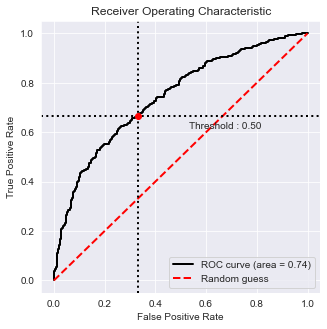

In [29]:
# Use predict_proba to predict probability of the class
y_pred = clf_2.predict_proba(X_test)[:,1]

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [30]:
print('ROC AUC score:', roc_auc_score(y_test, clf_2.predict(X_test)))
print('Accuracy score:', accuracy_score(y_test, clf_2.predict(X_test)))
print('Confusion matrix')
print(confusion_matrix(y_test, clf_2.predict(X_test)))

ROC AUC score: 0.6660996236686062
Accuracy score: 0.6661596958174905
Confusion matrix
[[450 223]
 [216 426]]


In [31]:
#The individual importance values for each of the input features
feature_importance_df = pd.DataFrame(clf_2.get_feature_importance(prettified=True))
feature_importance_df = feature_importance_df.iloc[:10]
feature_importance_df

,Feature Id,Importances
0,feature_6,19.667233
1,feature_46,14.555646
2,feature_8,3.030739
3,feature_1,2.798073
4,feature_47,2.771386
5,feature_21,1.467658
6,hs_50_3106,1.418674
7,hs_50_3458,1.301924
8,hs_25_0,1.266675
9,hs_25_7,1.228368


### XGBClassifier

In [45]:
# machine learning
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [47]:
#Using kfold cross validation
from sklearn.model_selection import KFold, cross_val_predict
kf = KFold(shuffle=True, random_state=42, n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])

In [48]:
from xgboost.sklearn import XGBClassifier
xgb=XGBClassifier(learning_rate=0.06, eval_metric='logloss', #n_estimators=1000,
                                max_depth=5,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
xgb.fit(X_train,y_train)
predict_12=xgb.predict(X_test)

In [49]:
print(accuracy_score(y_test,predict_12))
print(confusion_matrix(y_test,predict_12))
print(classification_report(y_test,predict_12))

0.6723259762308998
[[209  97]
 [ 96 187]]
              precision    recall  f1-score   support

           0       0.69      0.68      0.68       306
           1       0.66      0.66      0.66       283

    accuracy                           0.67       589
   macro avg       0.67      0.67      0.67       589
weighted avg       0.67      0.67      0.67       589



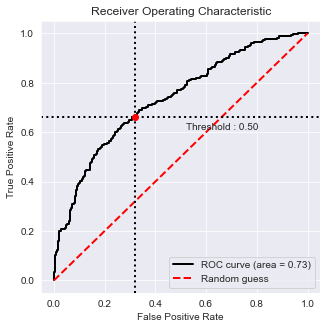

In [50]:
# Use predict_proba to predict probability of the class
y_pred = xgb.predict_proba(X_test)[:,1]

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

### Feature importance

In [51]:
results=pd.DataFrame()
results['columns']=X.columns
results['importances'] = xgb.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

results[:10]

,columns,importances
47,feature_46,0.013862
807,hs_50_756,0.011611
1318,hs_50_1267,0.010239
8,feature_6,0.010193
1430,hs_50_1379,0.009250
761,hs_50_710,0.009162
3199,hs_50_3148,0.009042
2929,hs_50_2878,0.007965
4235,hs_50_4184,0.007901
1824,hs_50_1773,0.007786


In [52]:
from matplotlib import pyplot

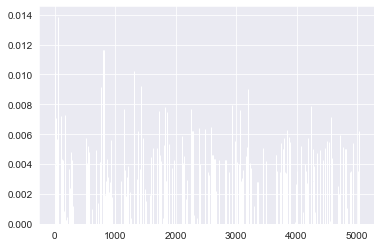

In [53]:
pyplot.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
pyplot.show()

In [54]:
cross_val_score(xgb, X_test, y_test, cv=5).mean()

0.651962914674779